In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import io
import numpy as np
import plotly.graph_objs as go
import plotly.tools as tls
import codecs
import geopandas as gpd
import requests

import squarify
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import imageio
imread = imageio.imread

from IPython.display import HTML
from matplotlib_venn import venn2
from subprocess import check_output


In [28]:
response=pd.read_csv('multipleChoiceResponses.csv',encoding='ISO-8859-1')
response.head()

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorExperienceLevel,JobFactorDepartment,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat important,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Male,Taiwan,38.0,Employed full-time,NaN,NaN,Yes,NaN,Computer Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
print('El número total de encuestados:',response.shape[0])
print('Número total de países con encuestados:',response['Country'].nunique())
print('País con mayor número de encuestados.:',response['Country'].value_counts().index[0],'con',response['Country'].value_counts().values[0],'encuestados')
print('Respondiente mas joven:',response['Age'].min(),' y el encuestado más viejo:',response['Age'].max())

El número total de encuestados: 16716
Número total de países con encuestados: 52
País con mayor número de encuestados.: United States con 4197 encuestados
Respondiente mas joven: 0.0  y el encuestado más viejo: 100.0


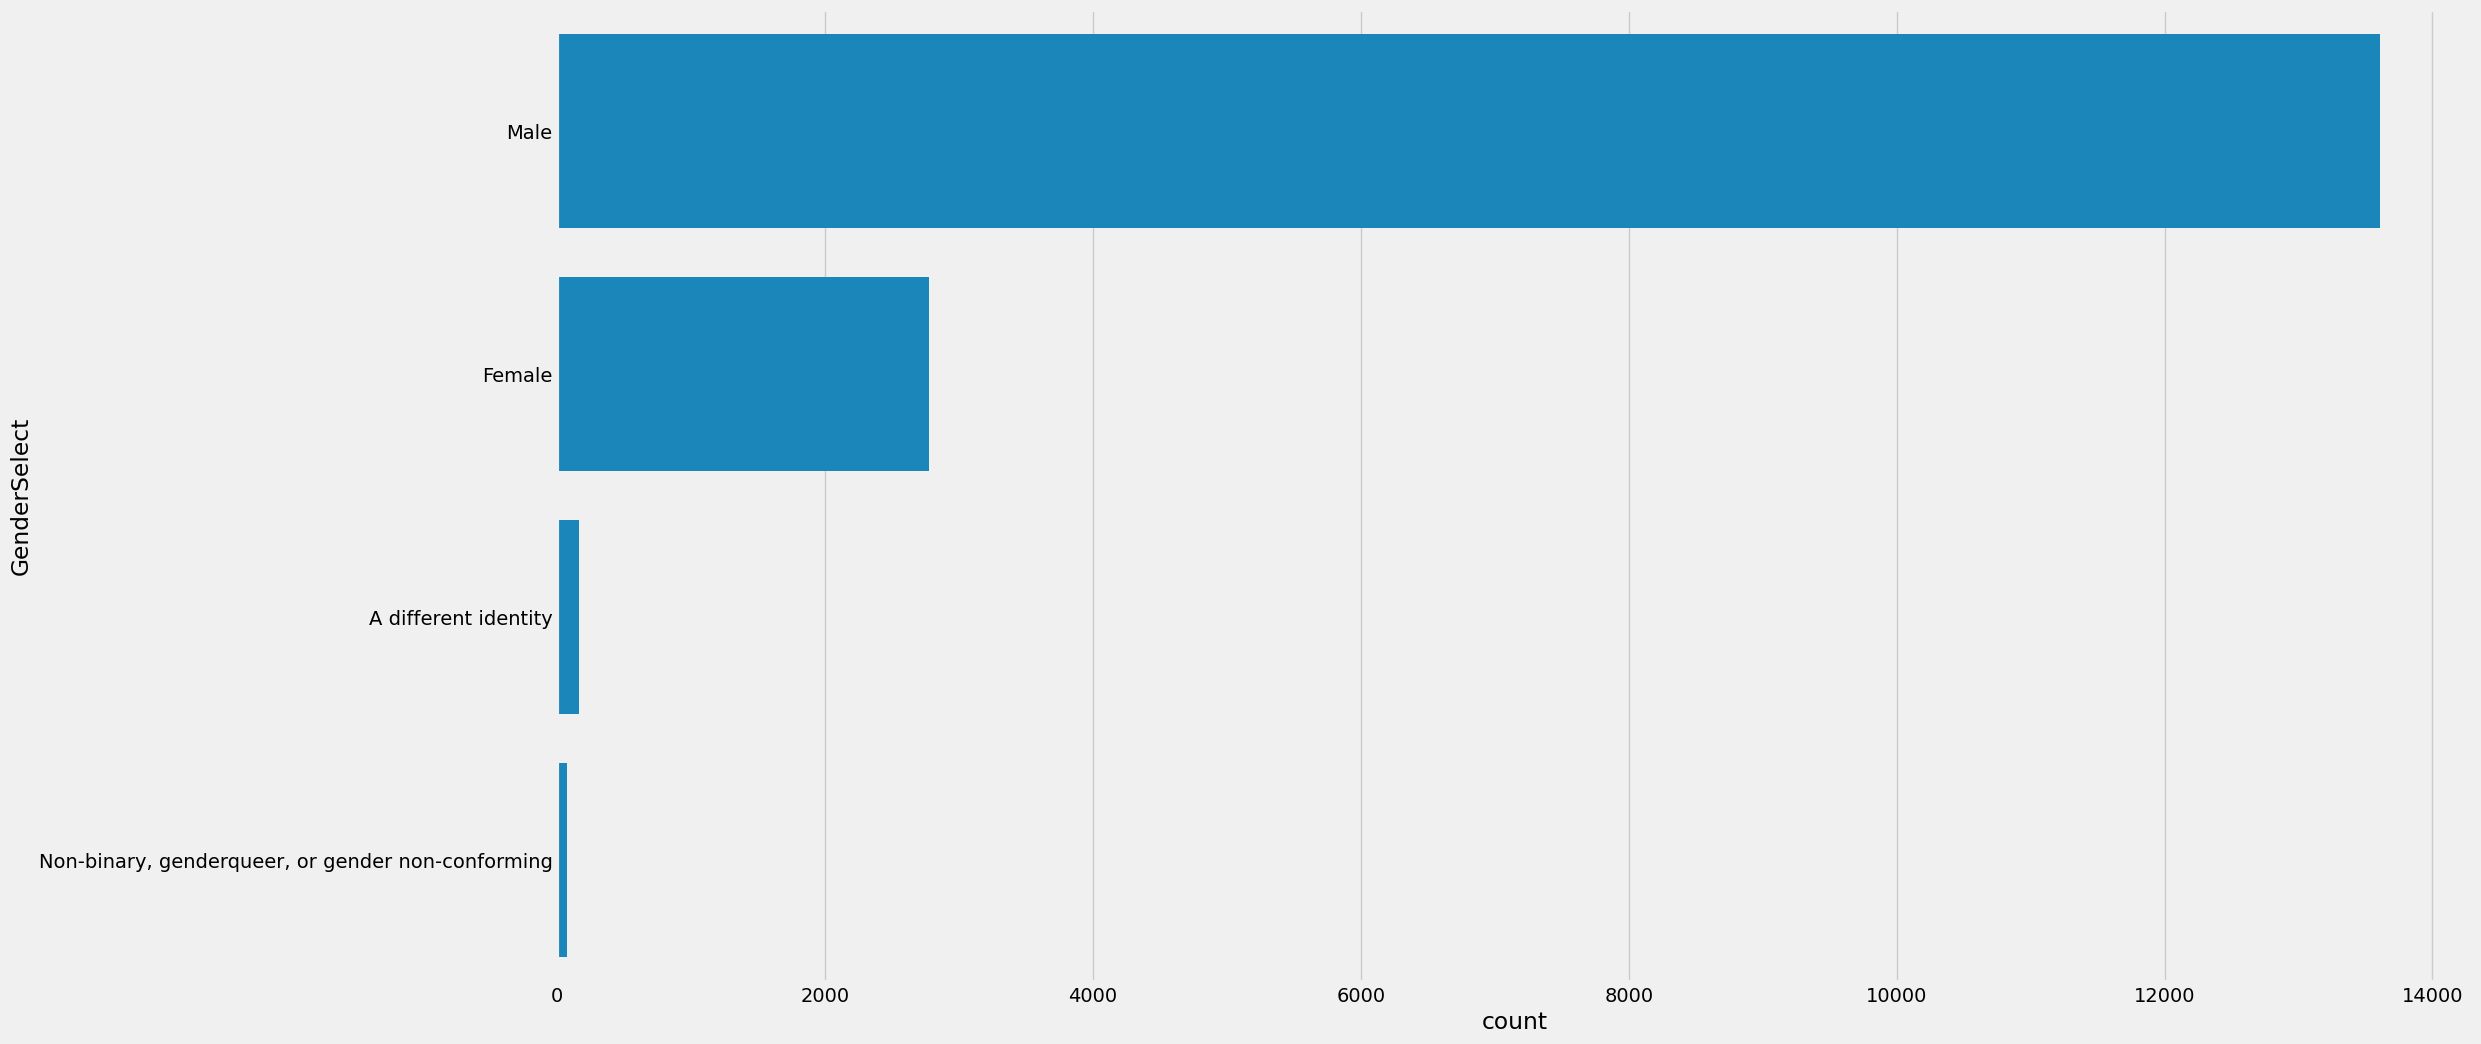

In [30]:
plt.subplots(figsize=(22,12))
sns.countplot(y=response['GenderSelect'],order=response['GenderSelect'].value_counts().index)
plt.show()

In [31]:
print(response.columns)

Index(['GenderSelect', 'Country', 'Age', 'EmploymentStatus', 'StudentStatus',
       'LearningDataScience', 'CodeWriter', 'CareerSwitcher',
       'CurrentJobTitleSelect', 'TitleFit',
       ...
       'JobFactorExperienceLevel', 'JobFactorDepartment', 'JobFactorTitle',
       'JobFactorCompanyFunding', 'JobFactorImpact', 'JobFactorRemote',
       'JobFactorIndustry', 'JobFactorLeaderReputation', 'JobFactorDiversity',
       'JobFactorPublishingOpportunity'],
      dtype='object', length=228)


In [32]:
#print(response['Country'].isnull().sum())

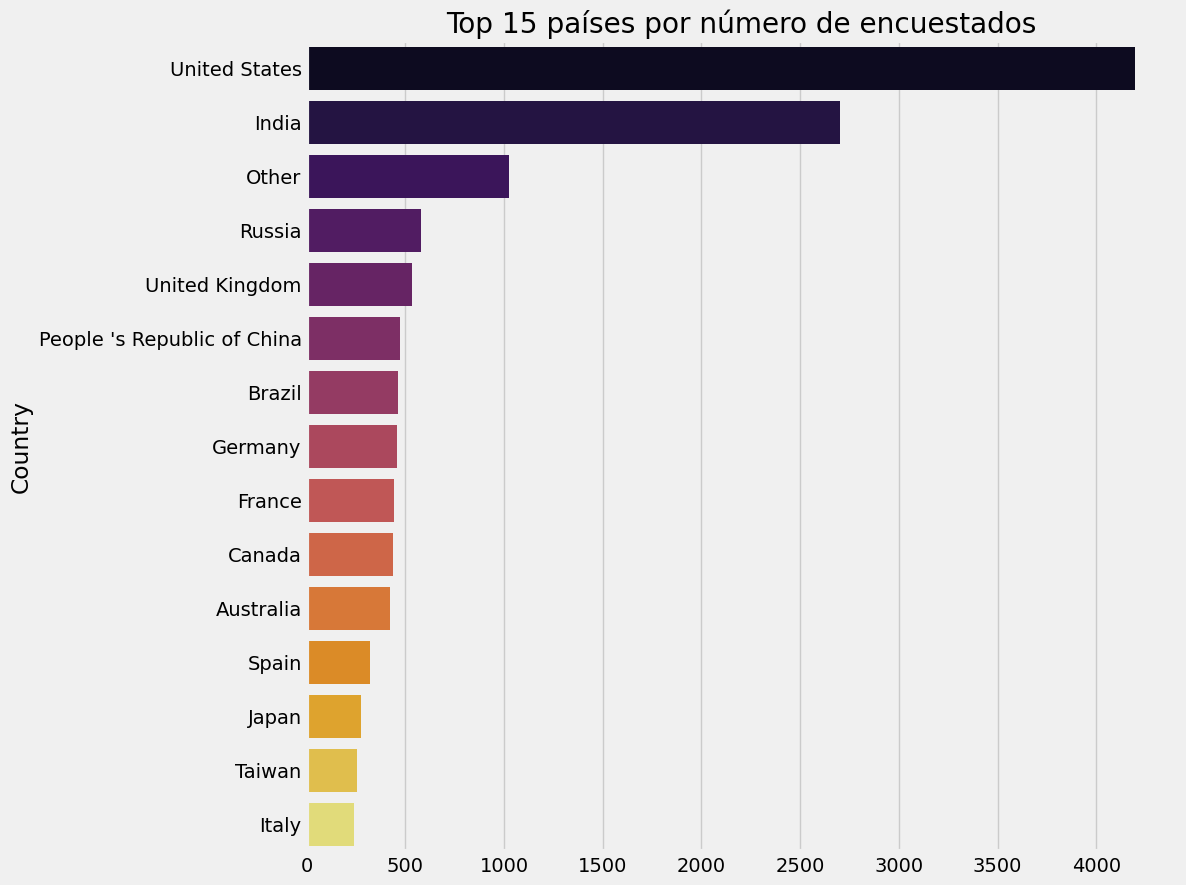

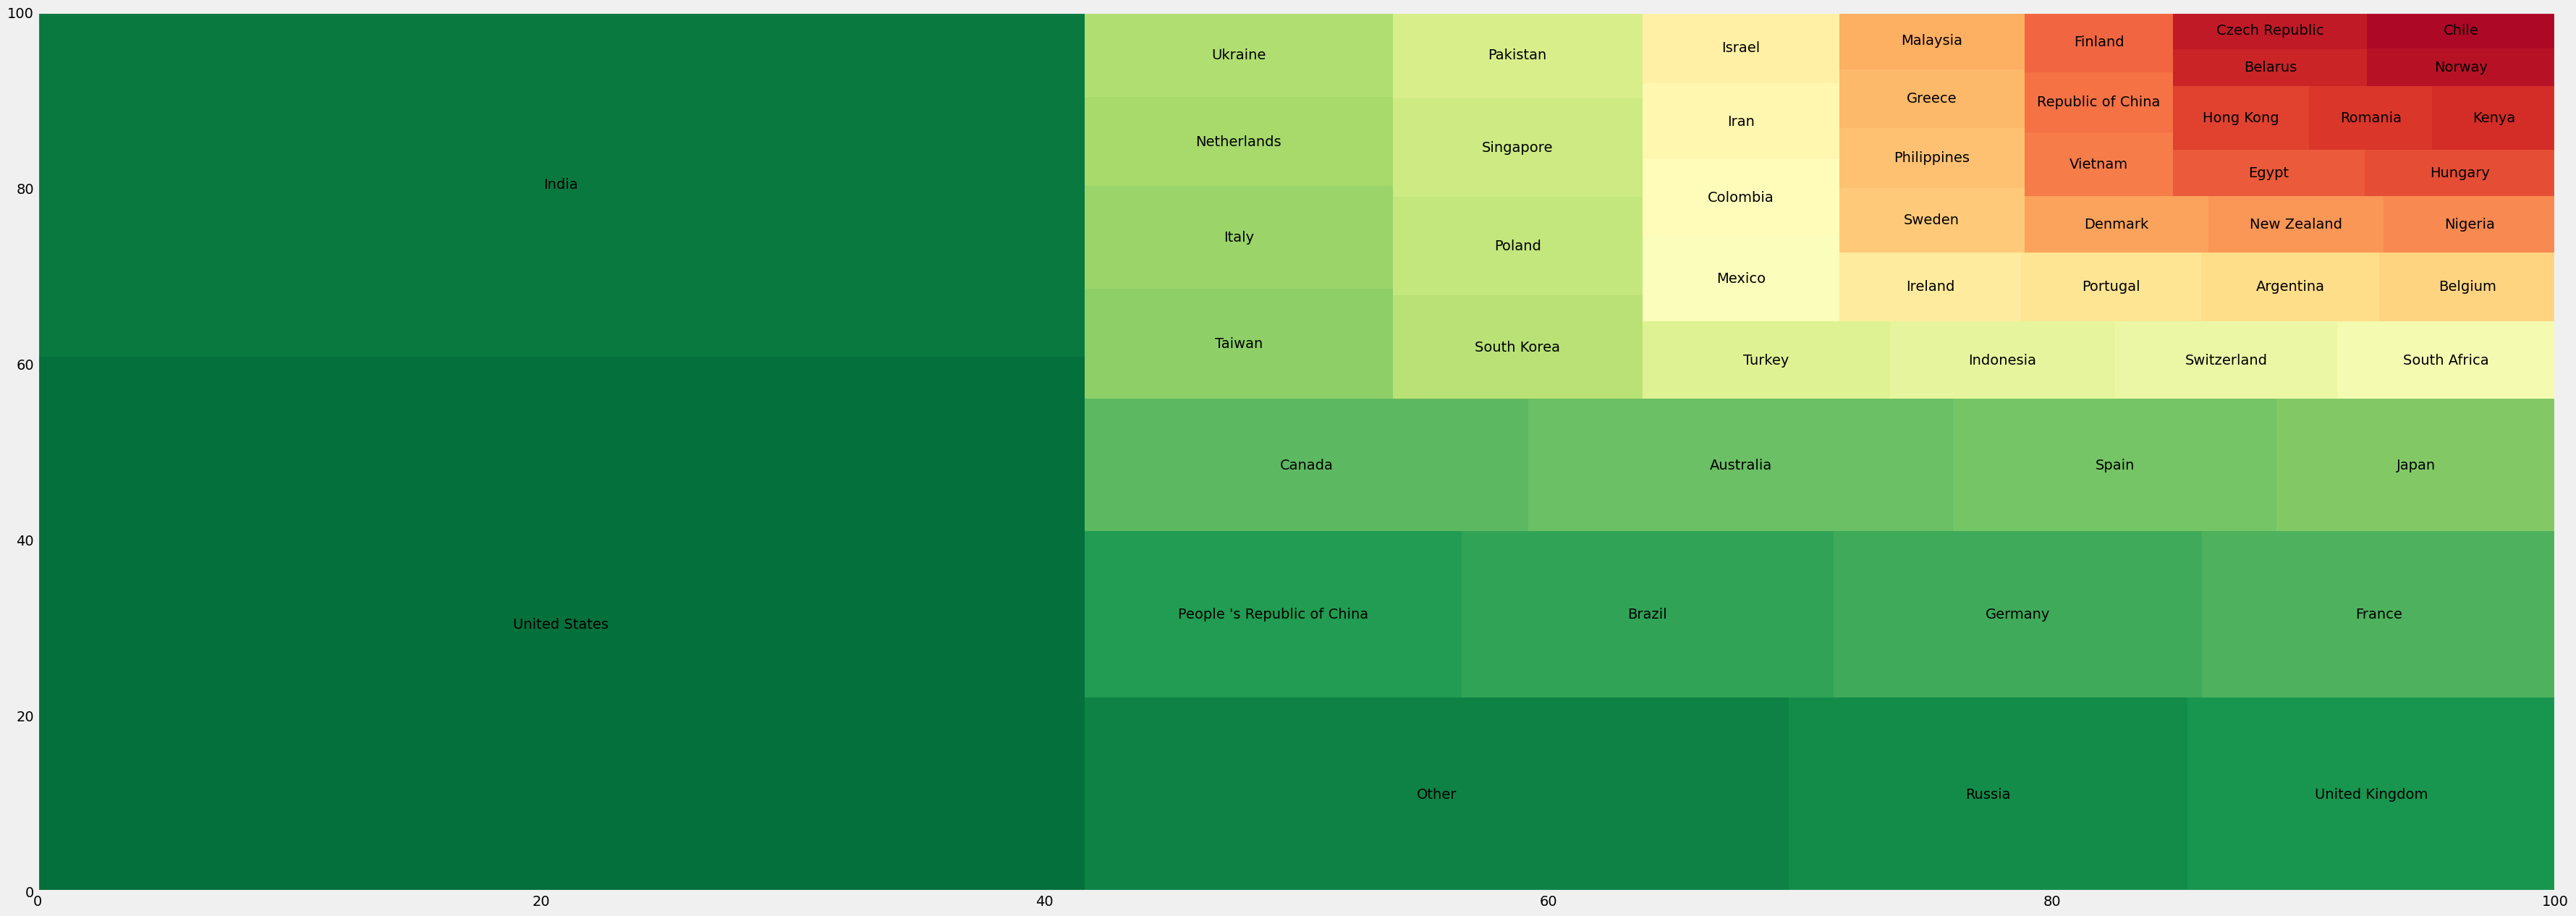

In [33]:
# Verificar si hay valores nulos en la columna 'Country' y eliminarlos si es necesario
response = response.dropna(subset=['Country'])

# Contar los 15 países con más encuestados
resp_coun = response['Country'].value_counts()[:15].to_frame()
resp_coun.columns = ['Count']  # Asignar un nombre a la columna

# Graficar el top 15 de países
sns.barplot(x=resp_coun['Count'], y=resp_coun.index, palette='inferno')
plt.title('Top 15 países por número de encuestados')
plt.xlabel('')
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

# Generar gráfico tipo treemap
tree = response['Country'].value_counts().to_frame()
tree.columns = ['Count']  # Asignar un nombre a la columna
squarify.plot(sizes=tree['Count'].values, label=tree.index, color=sns.color_palette('RdYlGn_r', 52))
plt.rcParams.update({'font.size': 20})
fig = plt.gcf()
fig.set_size_inches(40, 15)
plt.show()


In [34]:
response['CompensationAmount']=response['CompensationAmount'].str.replace(',','')
response['CompensationAmount']=response['CompensationAmount'].str.replace('-','')
rates=pd.read_csv('conversionRates.csv')
rates.drop('Unnamed: 0',axis=1,inplace=True)
salary=response[['CompensationAmount','CompensationCurrency','GenderSelect','Country','CurrentJobTitleSelect']].dropna()
salary=salary.merge(rates,left_on='CompensationCurrency',right_on='originCountry',how='left')
salary['Salary']=pd.to_numeric(salary['CompensationAmount'])*salary['exchangeRate']
print('El salario maximo es USD $',salary['Salary'].dropna().astype(int).max())
print('El salario minimo es USD $',salary['Salary'].dropna().astype(int).min())
print('El salario promedio es USD $',salary['Salary'].dropna().astype(int).median())

El salario maximo es USD $ 28297400000
El salario minimo es USD $ 0
El salario promedio es USD $ 53812.0


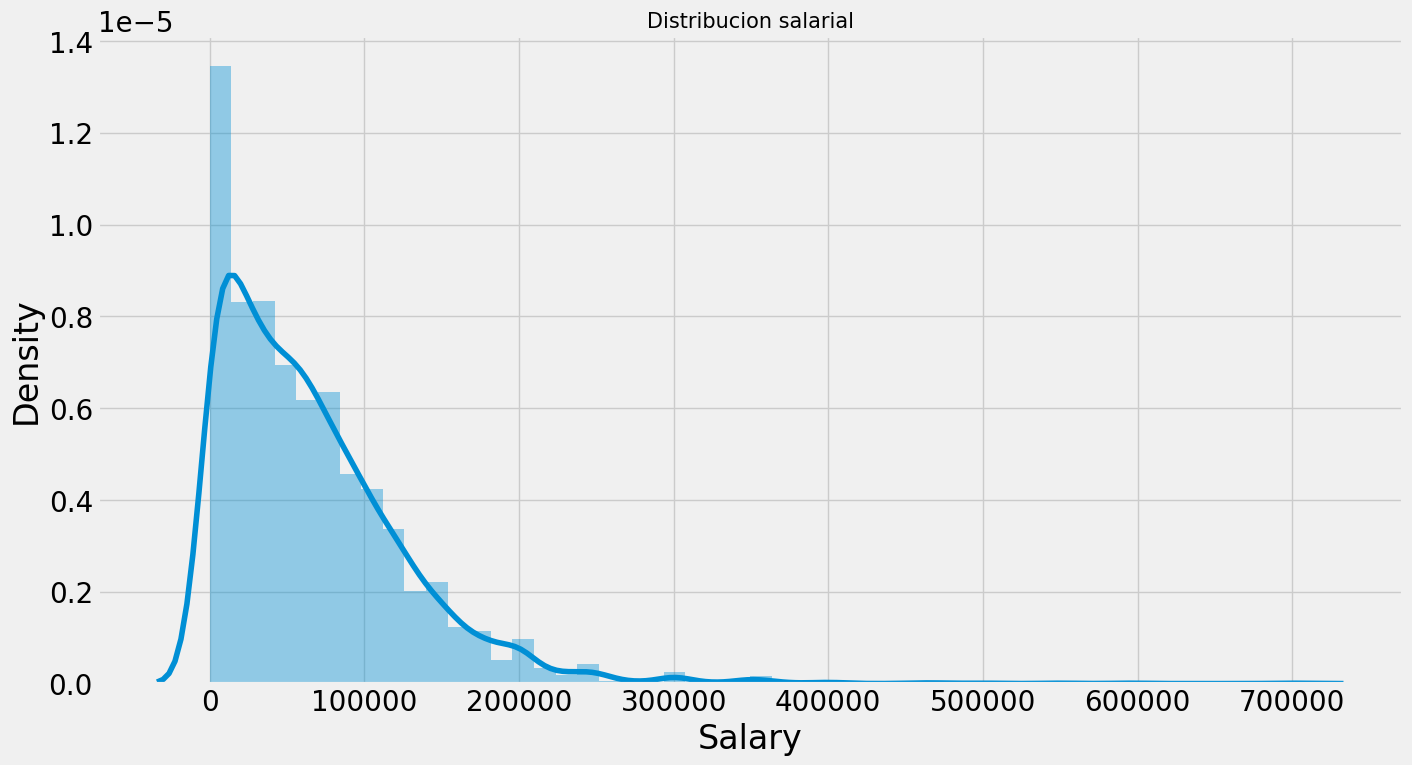

In [35]:
plt.subplots(figsize=(15,8))
salary=salary[salary['Salary']<1000000]
sns.distplot(salary['Salary'])
plt.title('Distribucion salarial',size=15)
plt.show()

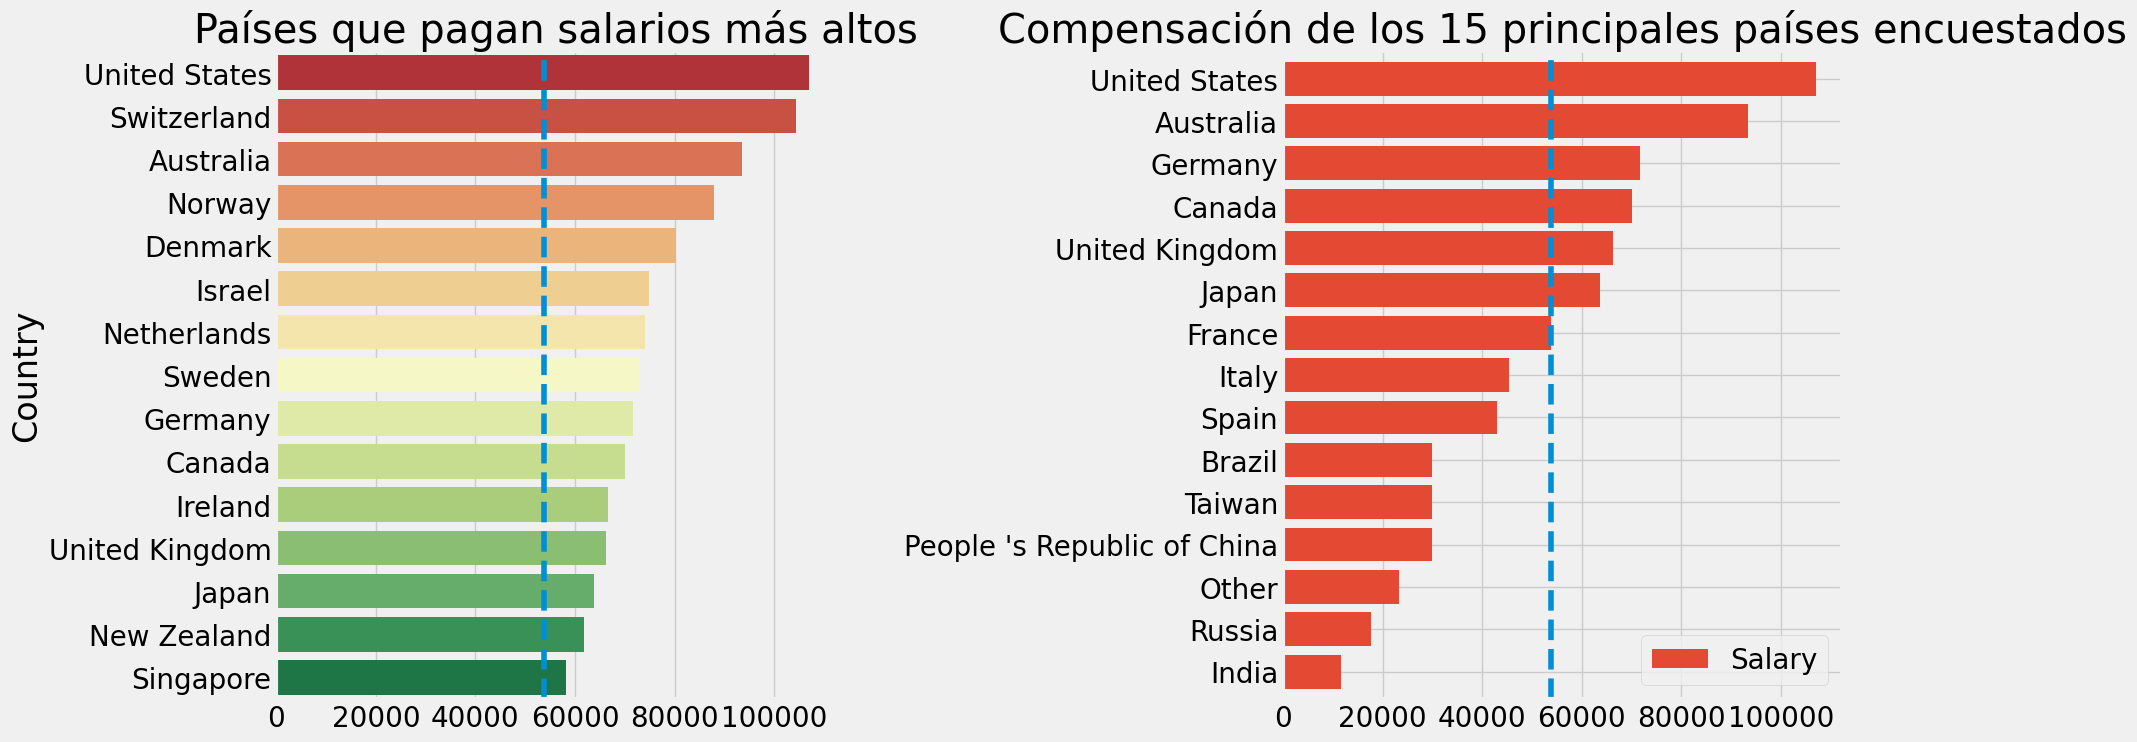

In [36]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Obtener los 15 países con los salarios más altos
sal_coun = salary.groupby('Country')['Salary'].median().sort_values(ascending=False)[:15].to_frame()

# Graficar los salarios más altos
sns.barplot(x='Salary', y=sal_coun.index, data=sal_coun, palette='RdYlGn', ax=ax[0])
ax[0].axvline(salary['Salary'].median(), linestyle='dashed')
ax[0].set_title('Países que pagan salarios más altos')
ax[0].set_xlabel('')

# Gráfico de compensación de los 15 principales países encuestados
max_coun = salary.groupby('Country')['Salary'].median().to_frame()
max_coun = max_coun[max_coun.index.isin(resp_coun.index)]
max_coun.sort_values(by='Salary', ascending=True).plot.barh(width=0.8, ax=ax[1], color=sns.color_palette('RdYlGn'))
ax[1].axvline(salary['Salary'].median(), linestyle='dashed')
ax[1].set_title('Compensación de los 15 principales países encuestados')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

# Ajustar la separación entre los gráficos
plt.subplots_adjust(wspace=0.8)
plt.show()


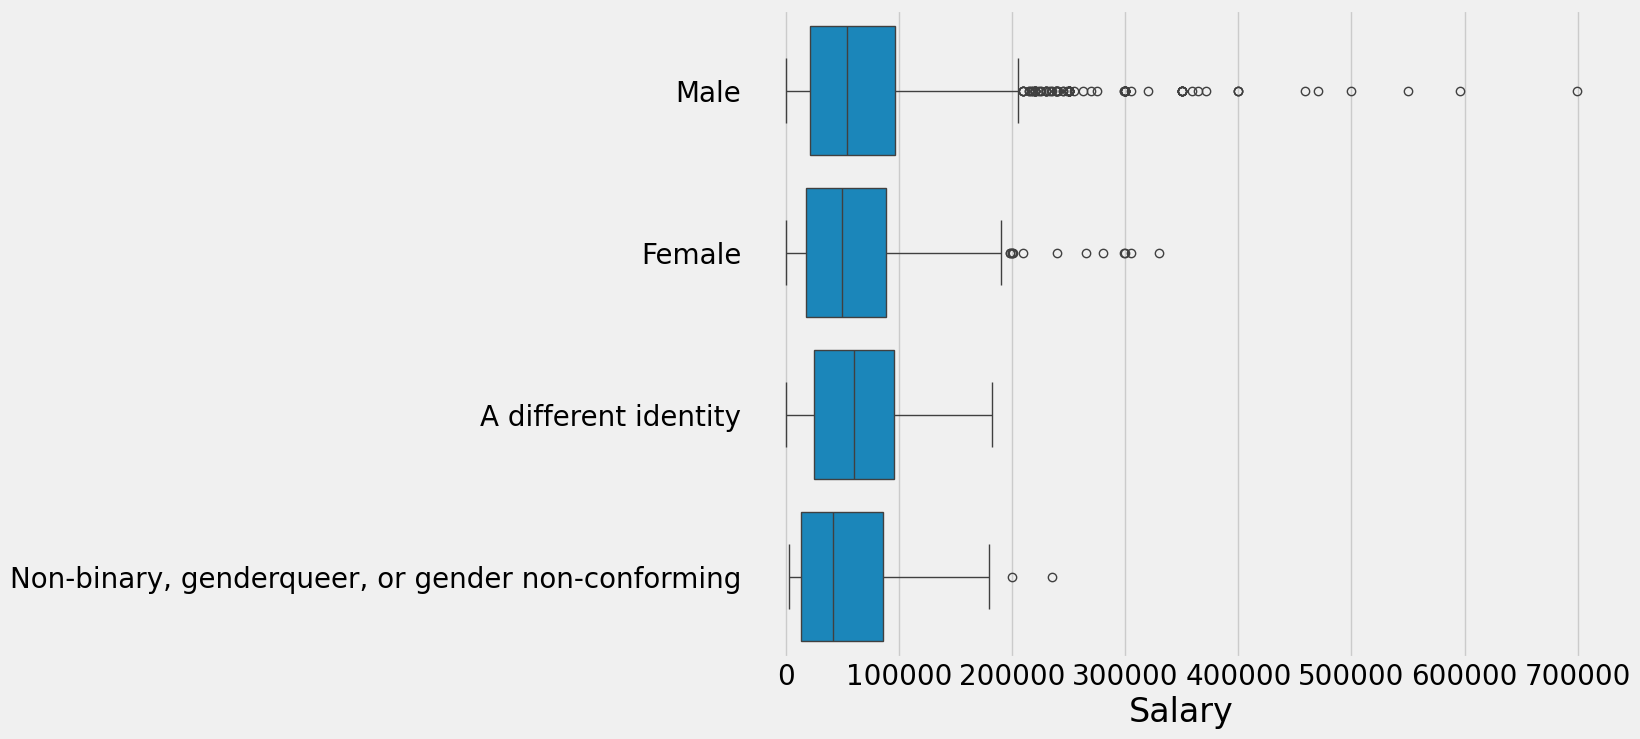

In [37]:
plt.subplots(figsize=(10,8))
sns.boxplot(y='GenderSelect',x='Salary',data=salary)
plt.ylabel('')
plt.show()

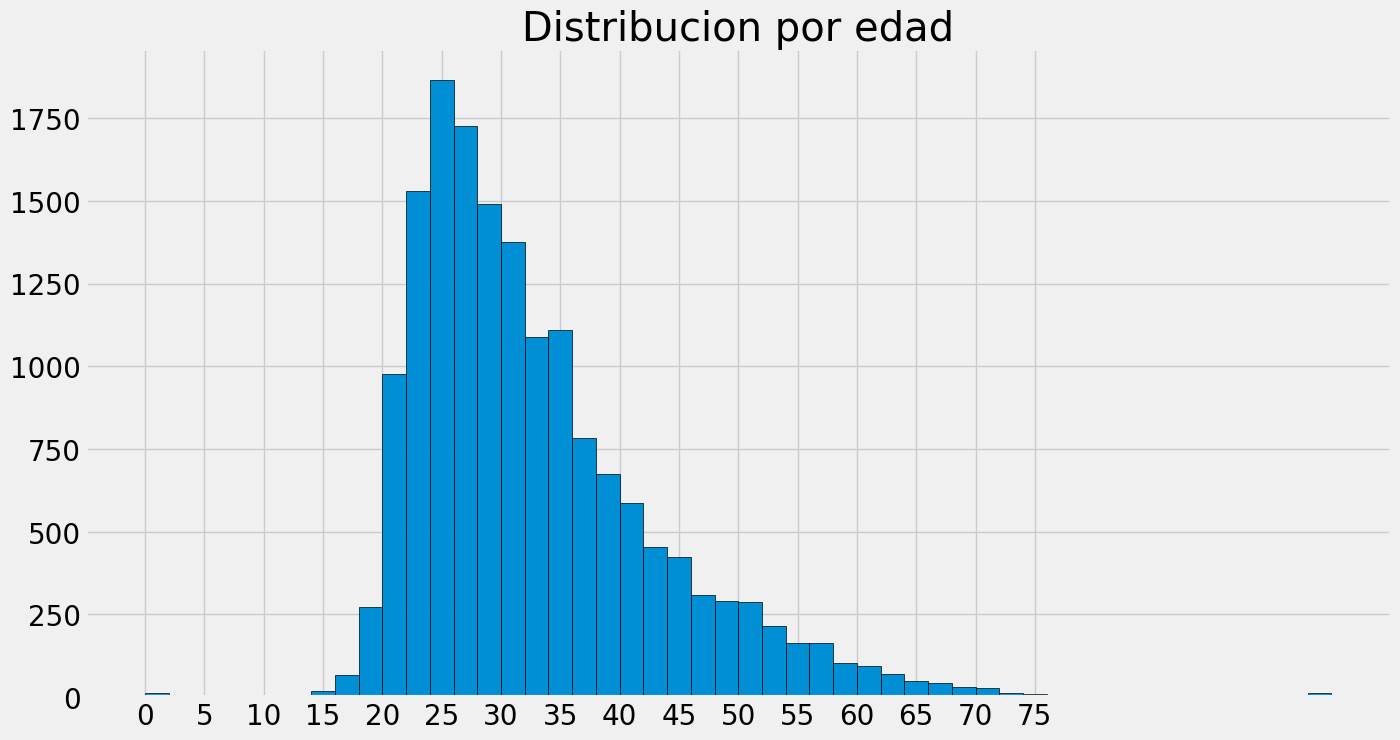

In [38]:
plt.subplots(figsize=(15,8))
response['Age'].hist(bins=50,edgecolor='black')
plt.xticks(list(range(0,80,5)))
plt.title('Distribucion por edad')
plt.show() 

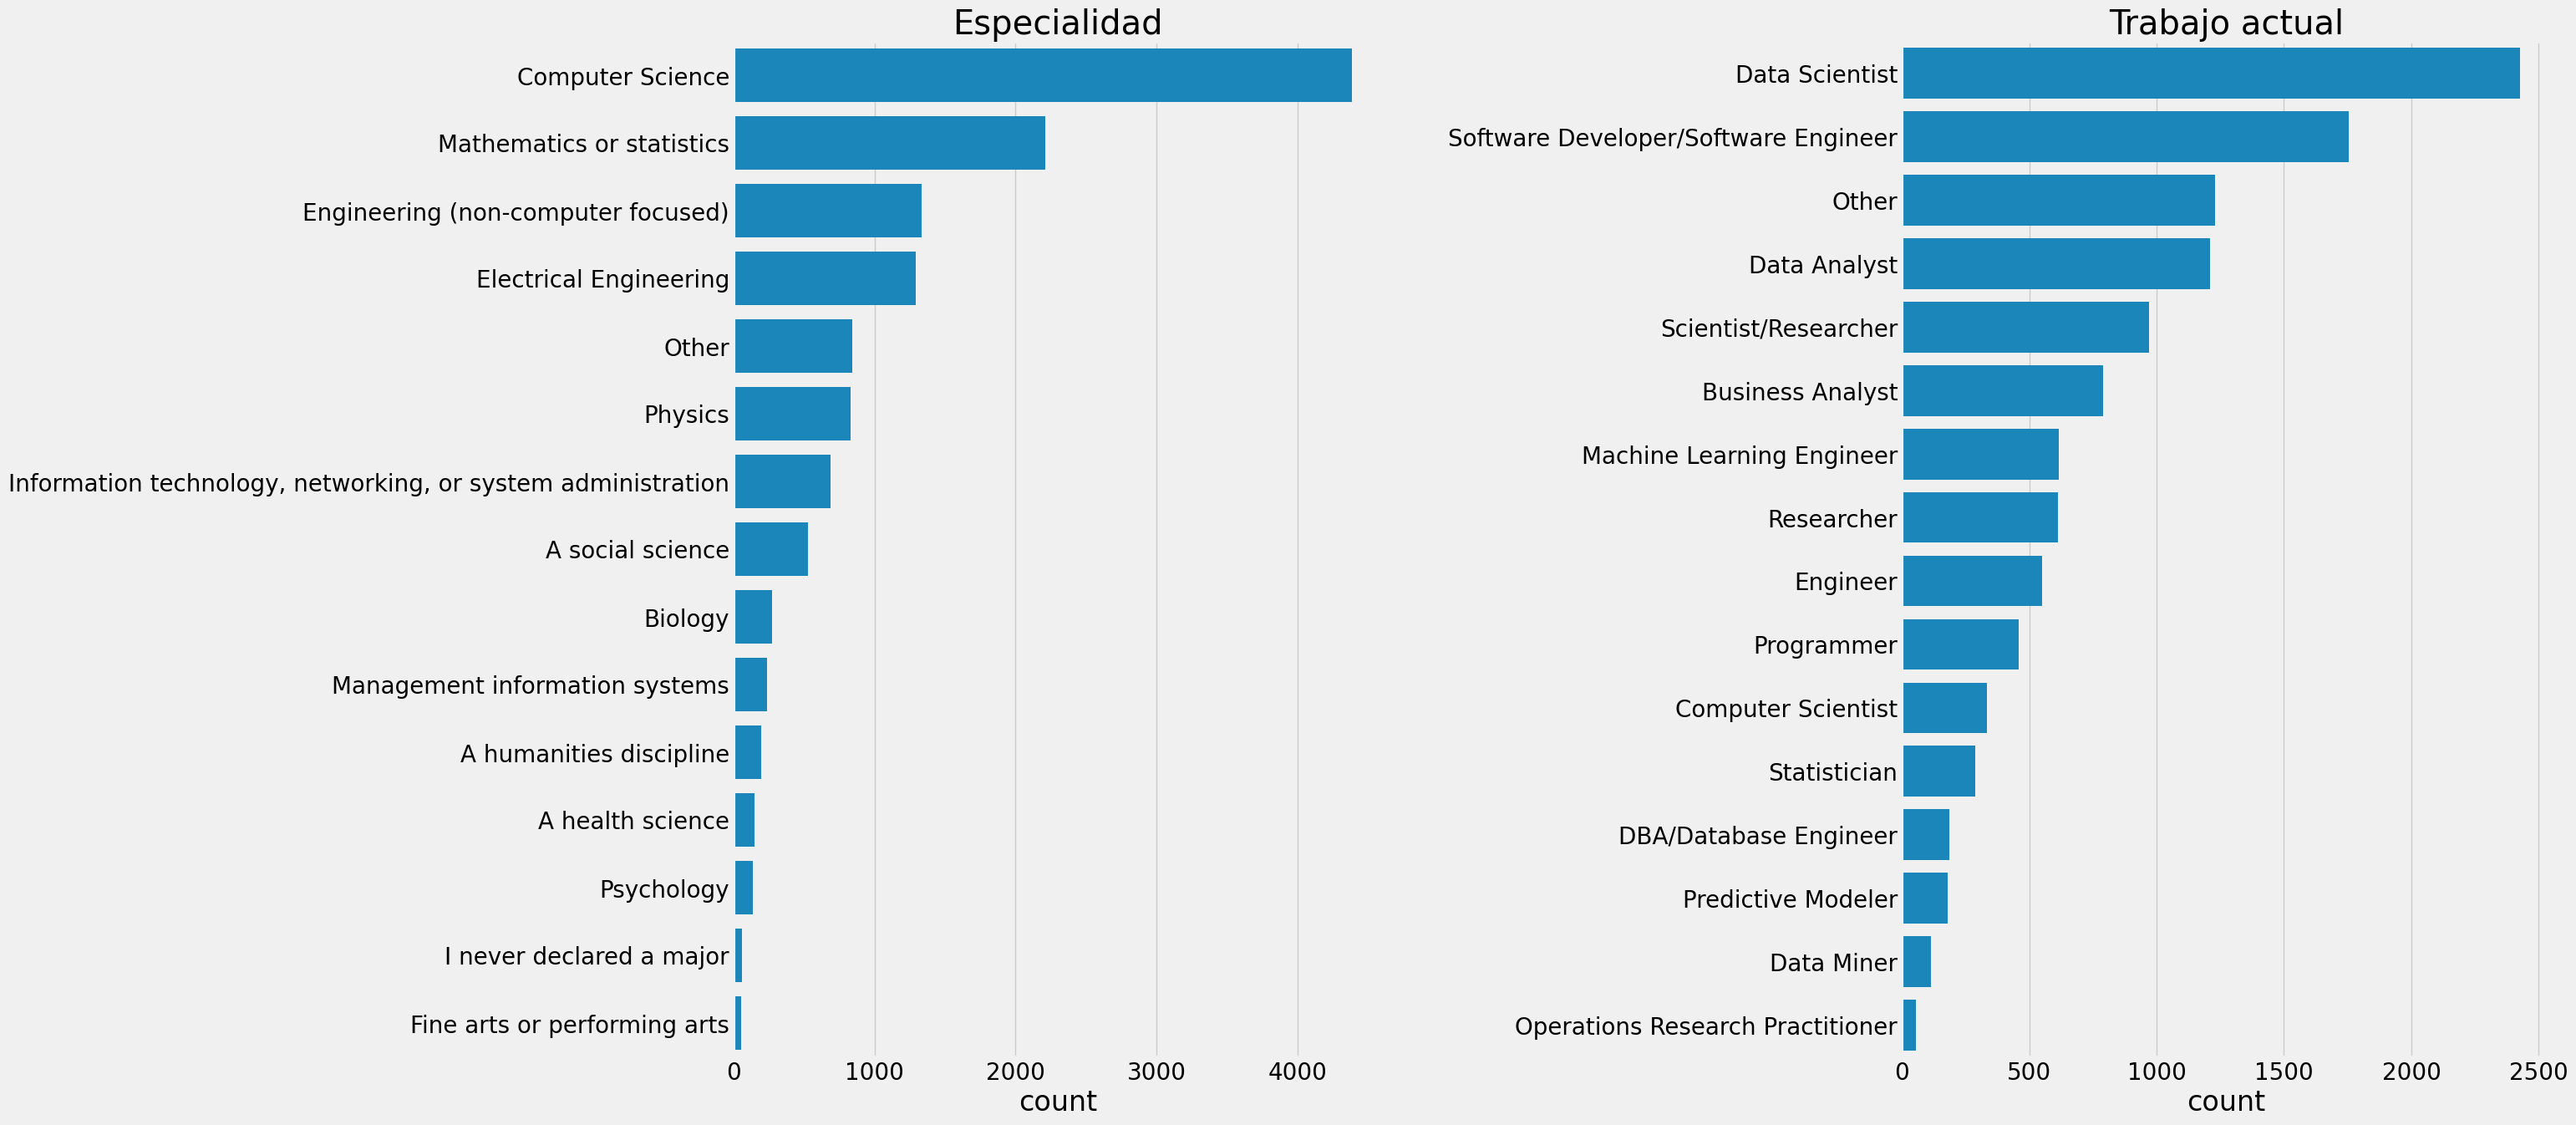

In [39]:
f,ax=plt.subplots(1,2,figsize=(25,15))
sns.countplot(y=response['MajorSelect'],ax=ax[0],order=response['MajorSelect'].value_counts().index)
ax[0].set_title('Especialidad')
ax[0].set_ylabel('')
sns.countplot(y=response['CurrentJobTitleSelect'],ax=ax[1],order=response['CurrentJobTitleSelect'].value_counts().index)
ax[1].set_title('Trabajo actual')
ax[1].set_ylabel('')
plt.subplots_adjust(wspace=0.8)
plt.show()

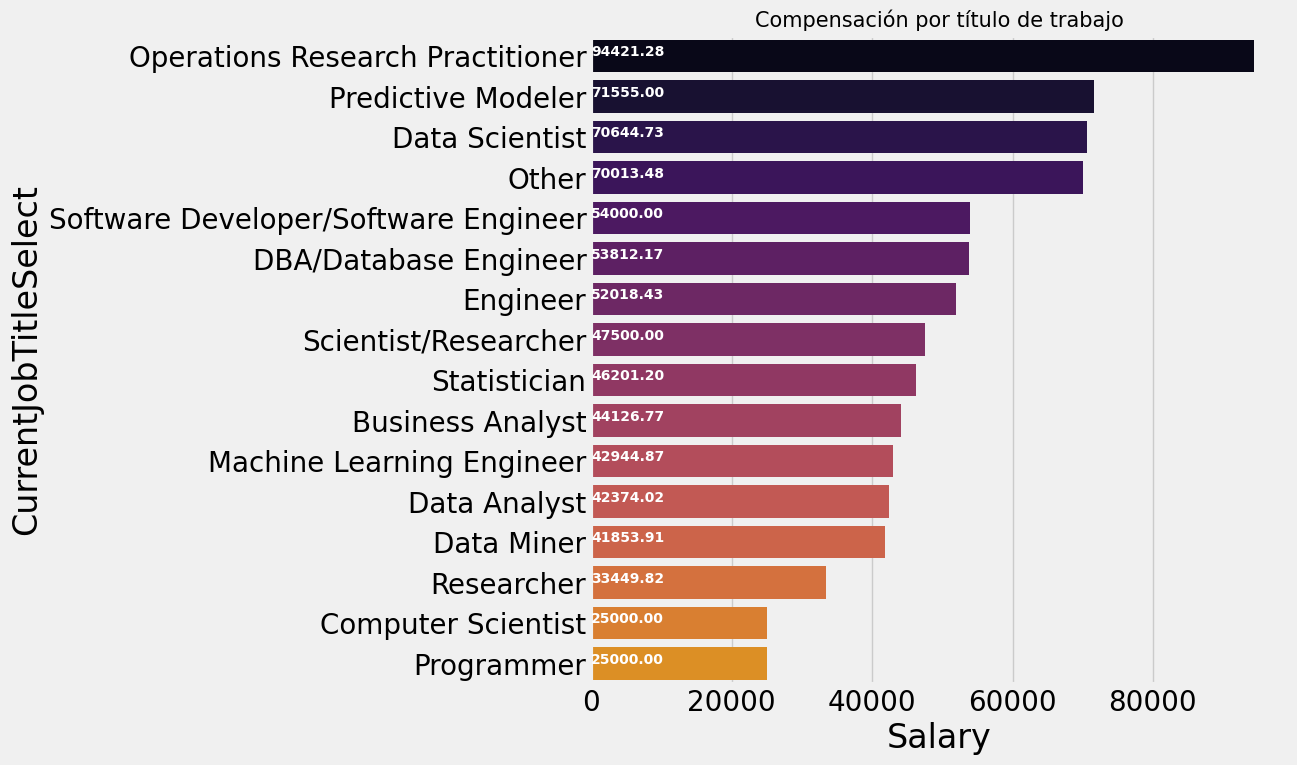

In [40]:
# Agrupar y ordenar los datos por salario
sal_job = salary.groupby('CurrentJobTitleSelect')['Salary'].median().to_frame().sort_values(by='Salary', ascending=False)

# Graficar los salarios por título de trabajo
ax = sns.barplot(x='Salary', y=sal_job.index, data=sal_job, palette=sns.color_palette('inferno', 20))

# Título del gráfico
plt.title('Compensación por título de trabajo', size=15)

# Agregar los valores de salario en el gráfico
for i, v in enumerate(sal_job.Salary): 
    ax.text(.5, i, f'{v:.2f}', fontsize=10, color='white', weight='bold')

# Ajustar el tamaño del gráfico
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show()


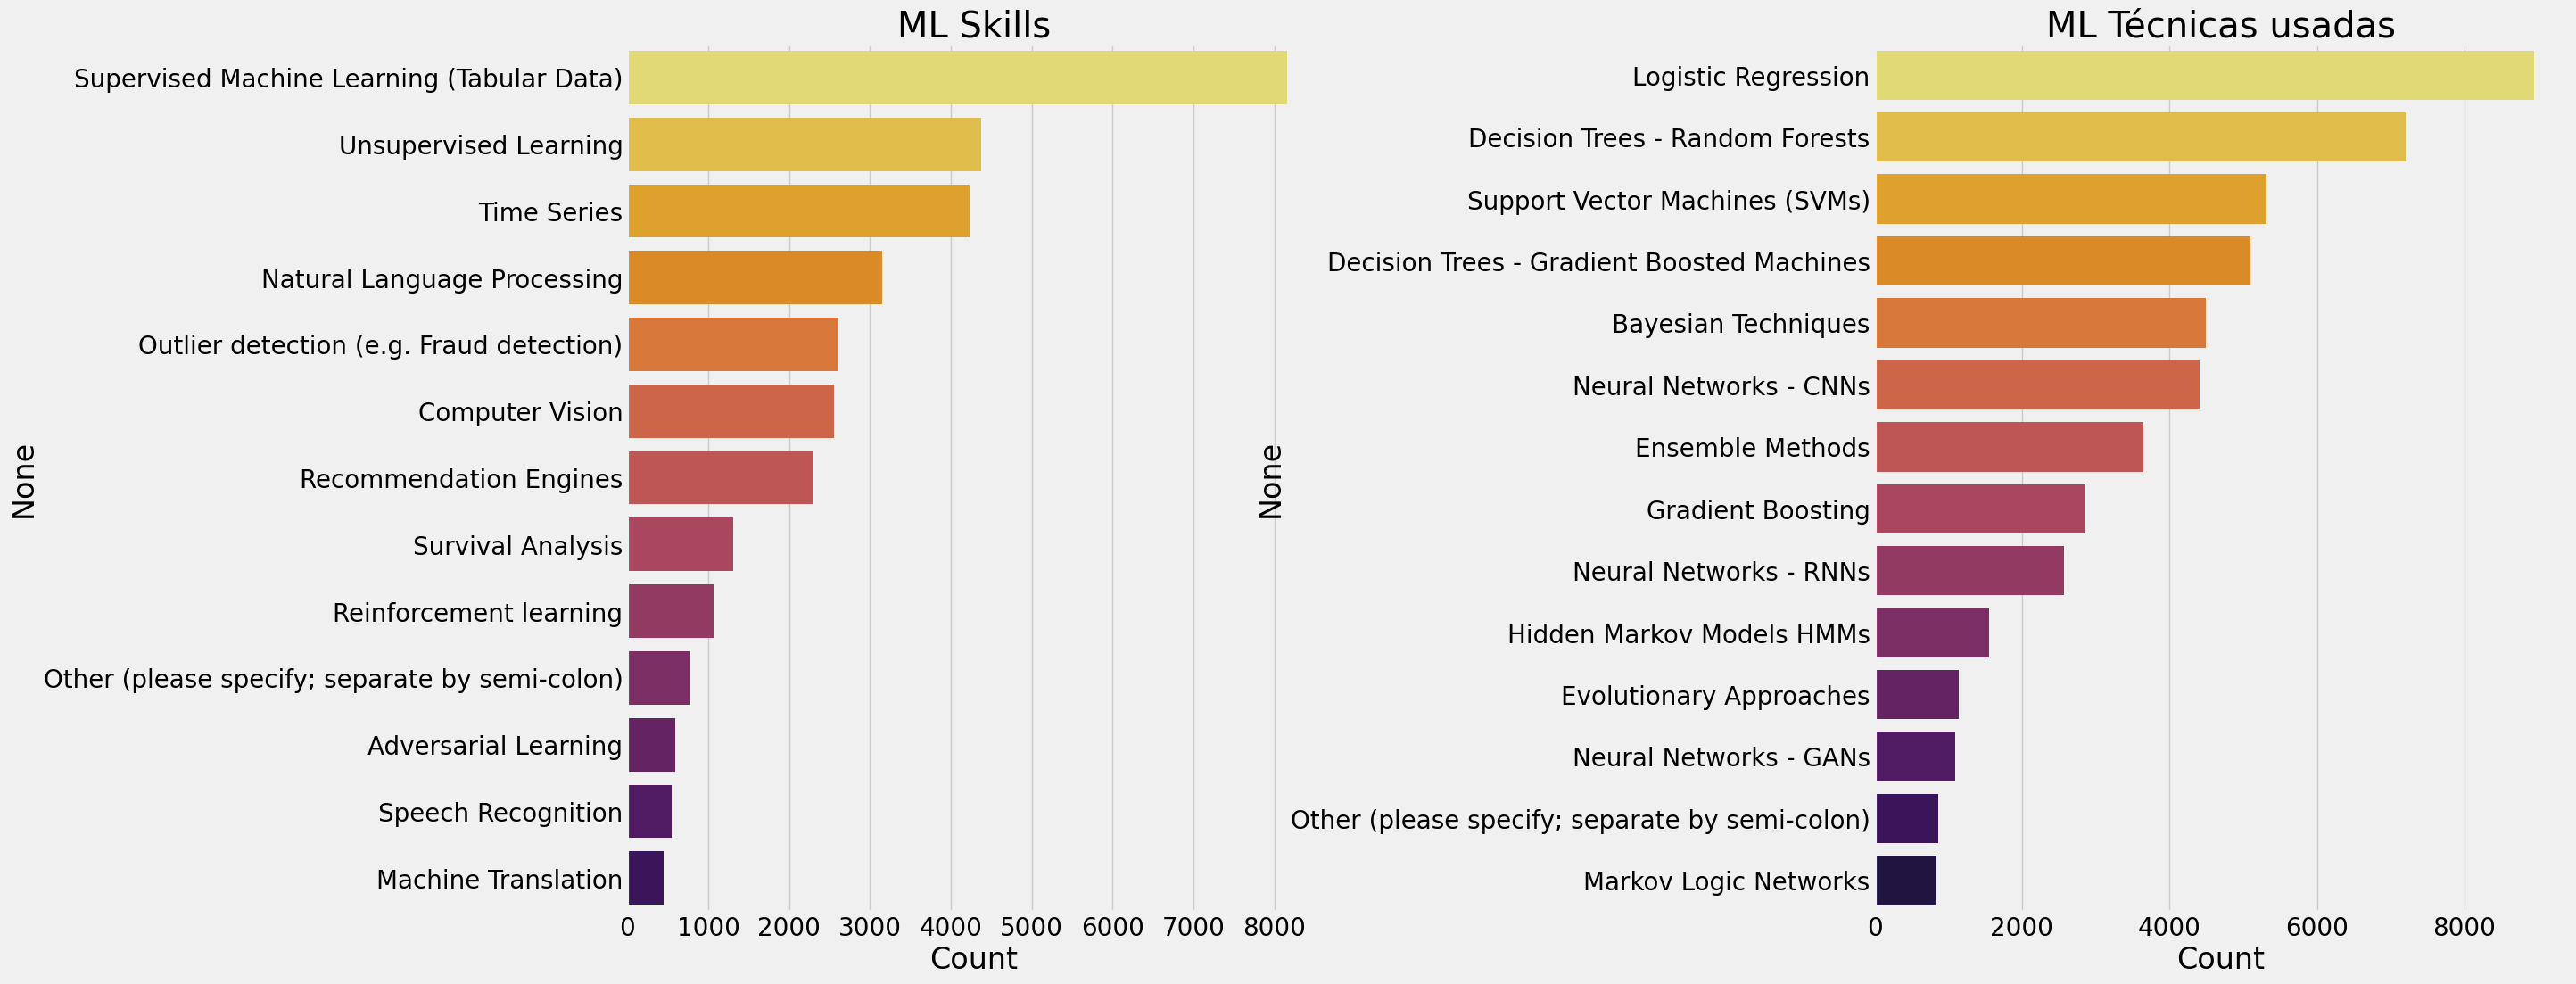

In [41]:
f, ax = plt.subplots(1, 2, figsize=(25, 12))

# Procesar las habilidades de ML
skills = response['MLSkillsSelect'].str.split(',')
skills_set = []
for i in skills.dropna():
    skills_set.extend(i)

# Crear el gráfico para las habilidades de ML
plt1 = pd.Series(skills_set).value_counts().sort_values(ascending=False).to_frame()
plt1.columns = ['Count']  # Asignar un nombre a la columna

# Graficar habilidades de ML
sns.barplot(x='Count', y=plt1.index, data=plt1, ax=ax[0], palette=sns.color_palette('inferno_r', 15))
ax[0].set_title('ML Skills')

# Procesar las técnicas de ML
tech = response['MLTechniquesSelect'].str.split(',')
techniques = []
for i in tech.dropna():
    techniques.extend(i)

# Crear el gráfico para las técnicas de ML
plt2 = pd.Series(techniques).value_counts().sort_values(ascending=False).to_frame()
plt2.columns = ['Count']  # Asignar un nombre a la columna

# Graficar técnicas de ML
sns.barplot(x='Count', y=plt2.index, data=plt2, ax=ax[1], palette=sns.color_palette('inferno_r', 15))
ax[1].set_title('ML Técnicas usadas')

# Ajustar el espacio entre los gráficos
plt.subplots_adjust(wspace=0.8)
plt.show()

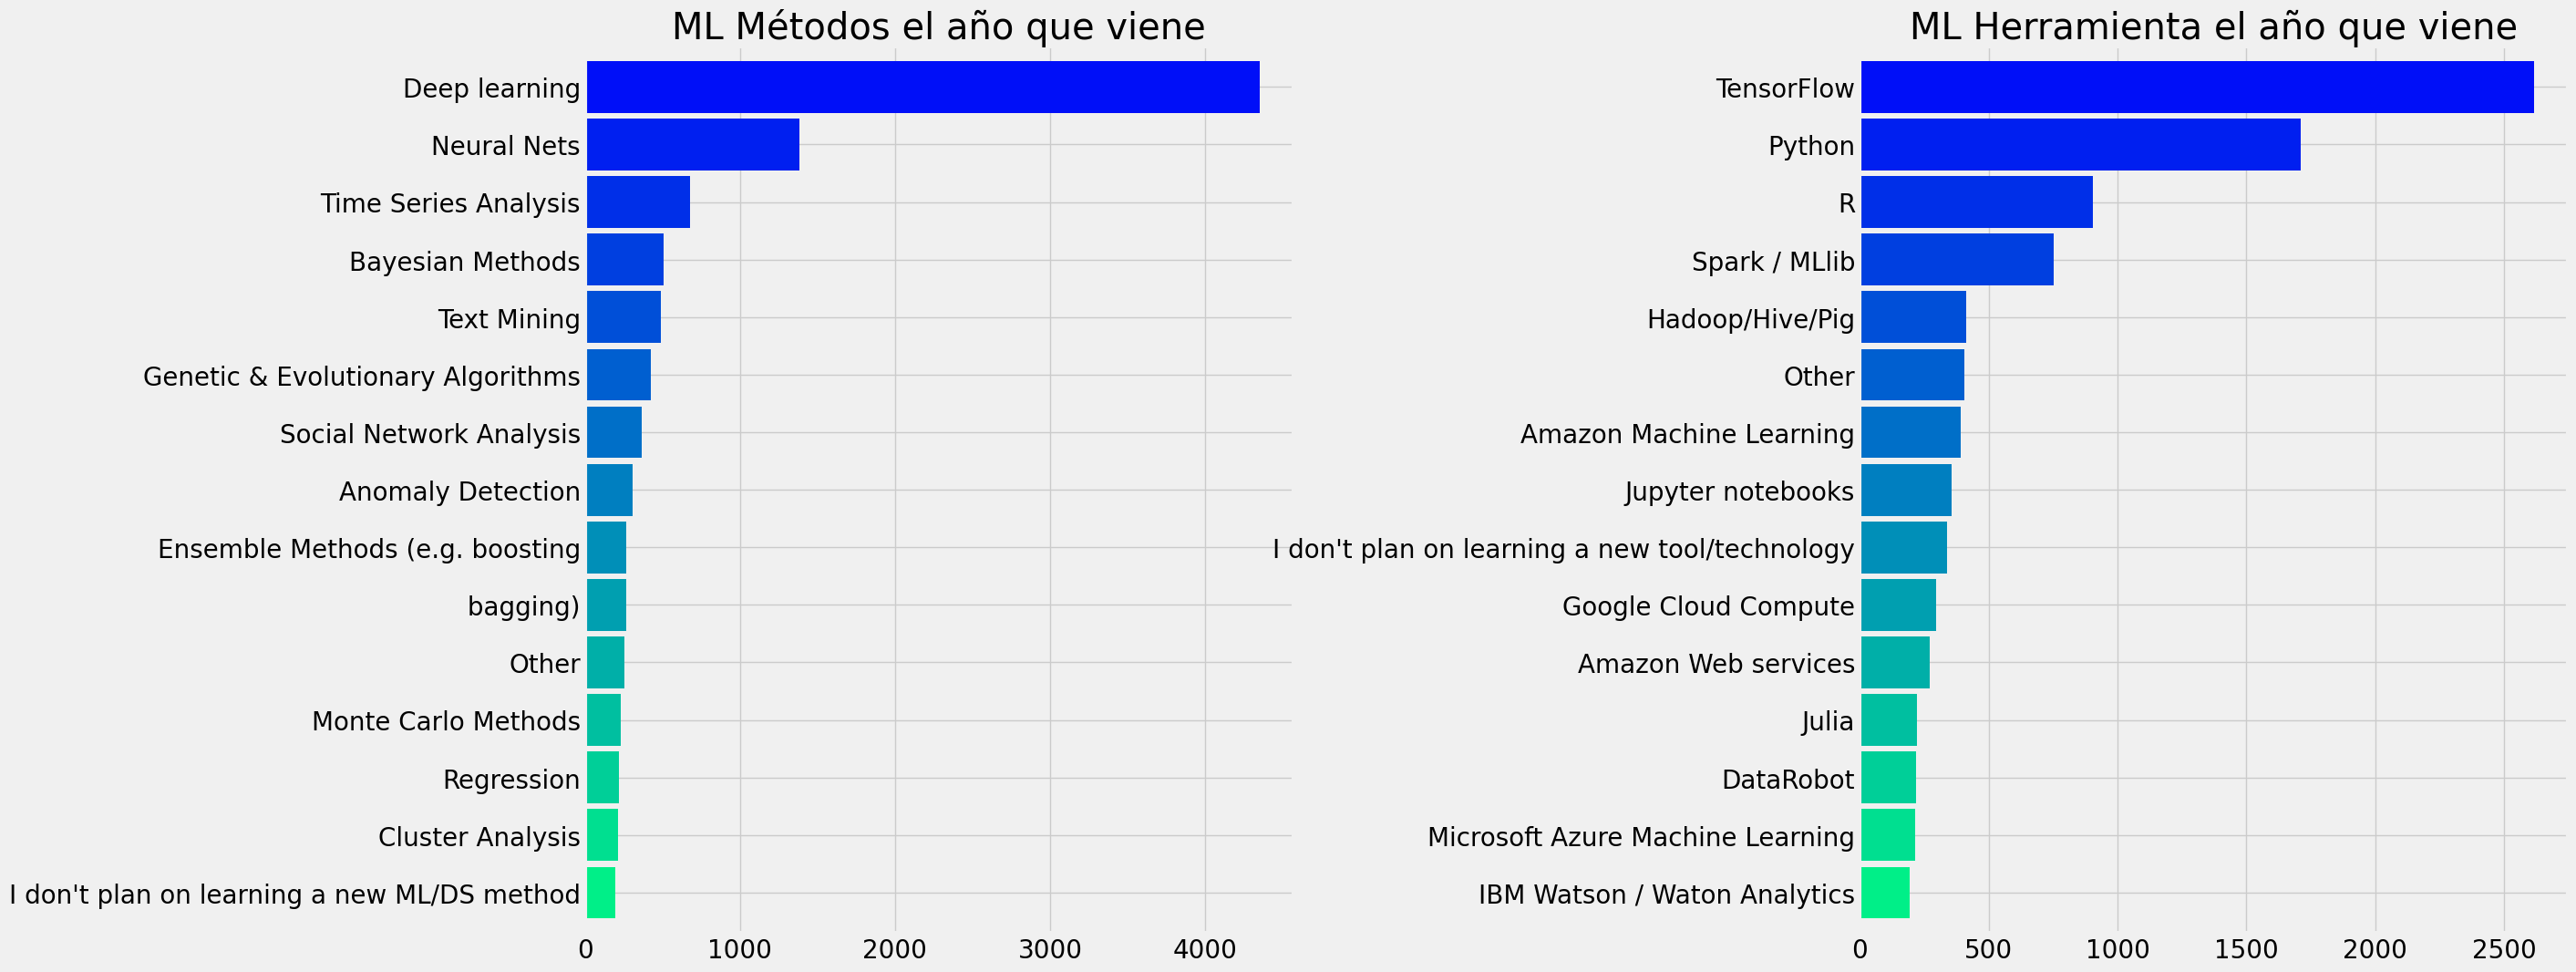

In [42]:
f,ax=plt.subplots(1,2,figsize=(25,12))
ml_nxt=response['MLMethodNextYearSelect'].str.split(',')
nxt_year=[]
for i in ml_nxt.dropna():
    nxt_year.extend(i)
pd.Series(nxt_year).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('winter_r',15),ax=ax[0])
tool=response['MLToolNextYearSelect'].str.split(',')
tool_nxt=[]
for i in tool.dropna():
    tool_nxt.extend(i)
pd.Series(tool_nxt).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('winter_r',15),ax=ax[1])
plt.subplots_adjust(wspace=0.8)
ax[0].set_title('ML Métodos el año que viene')
ax[1].set_title('ML Herramienta el año que viene')
plt.show()

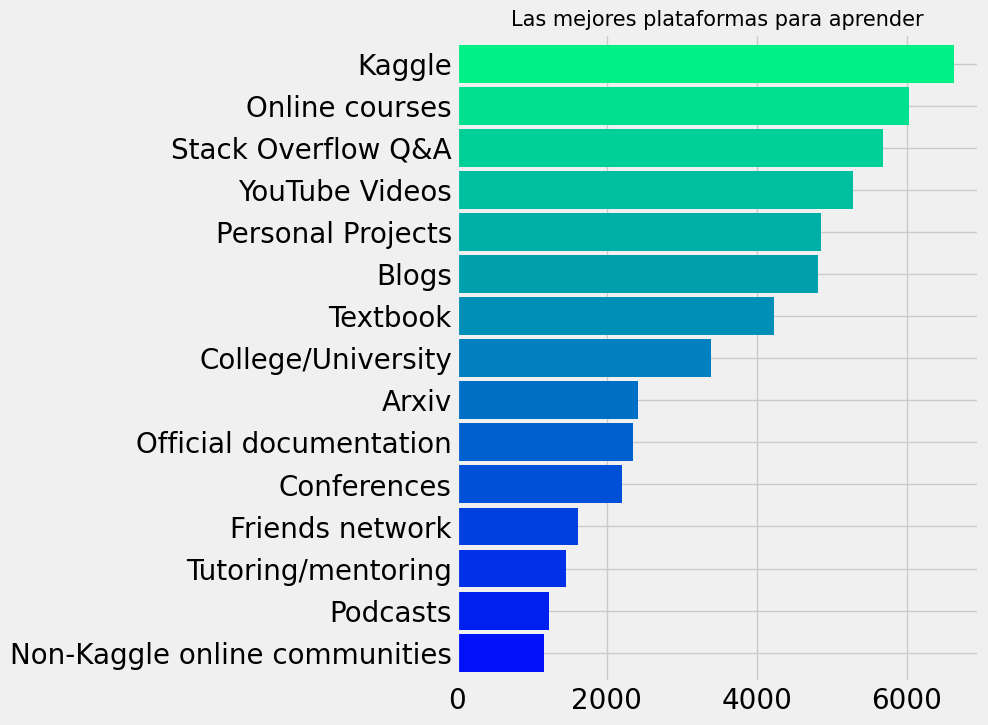

In [43]:
plt.subplots(figsize=(6,8))
learn=response['LearningPlatformSelect'].str.split(',')
platform=[]
for i in learn.dropna():
    platform.extend(i)
pd.Series(platform).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('winter',15))
plt.title('Las mejores plataformas para aprender',size=15)
plt.show()

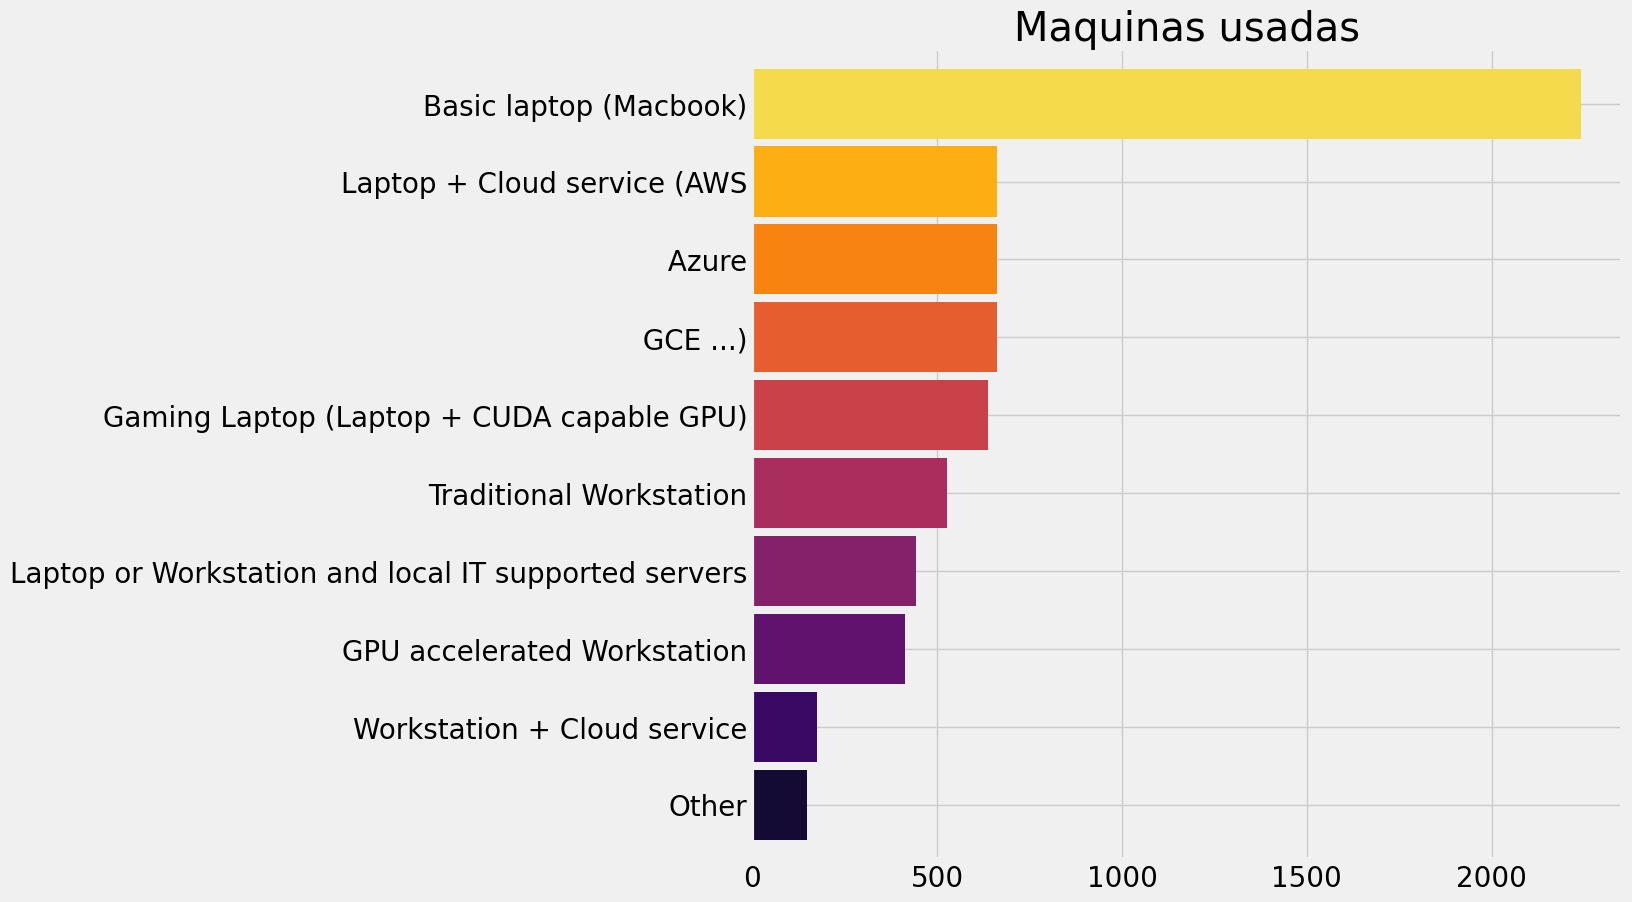

In [44]:
plt.subplots(figsize=(10,10))
hard=response['HardwarePersonalProjectsSelect'].str.split(',')
hardware=[]
for i in hard.dropna():
    hardware.extend(i)
pd.Series(hardware).value_counts().sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('inferno',10))
plt.title('Maquinas usadas')
plt.show()

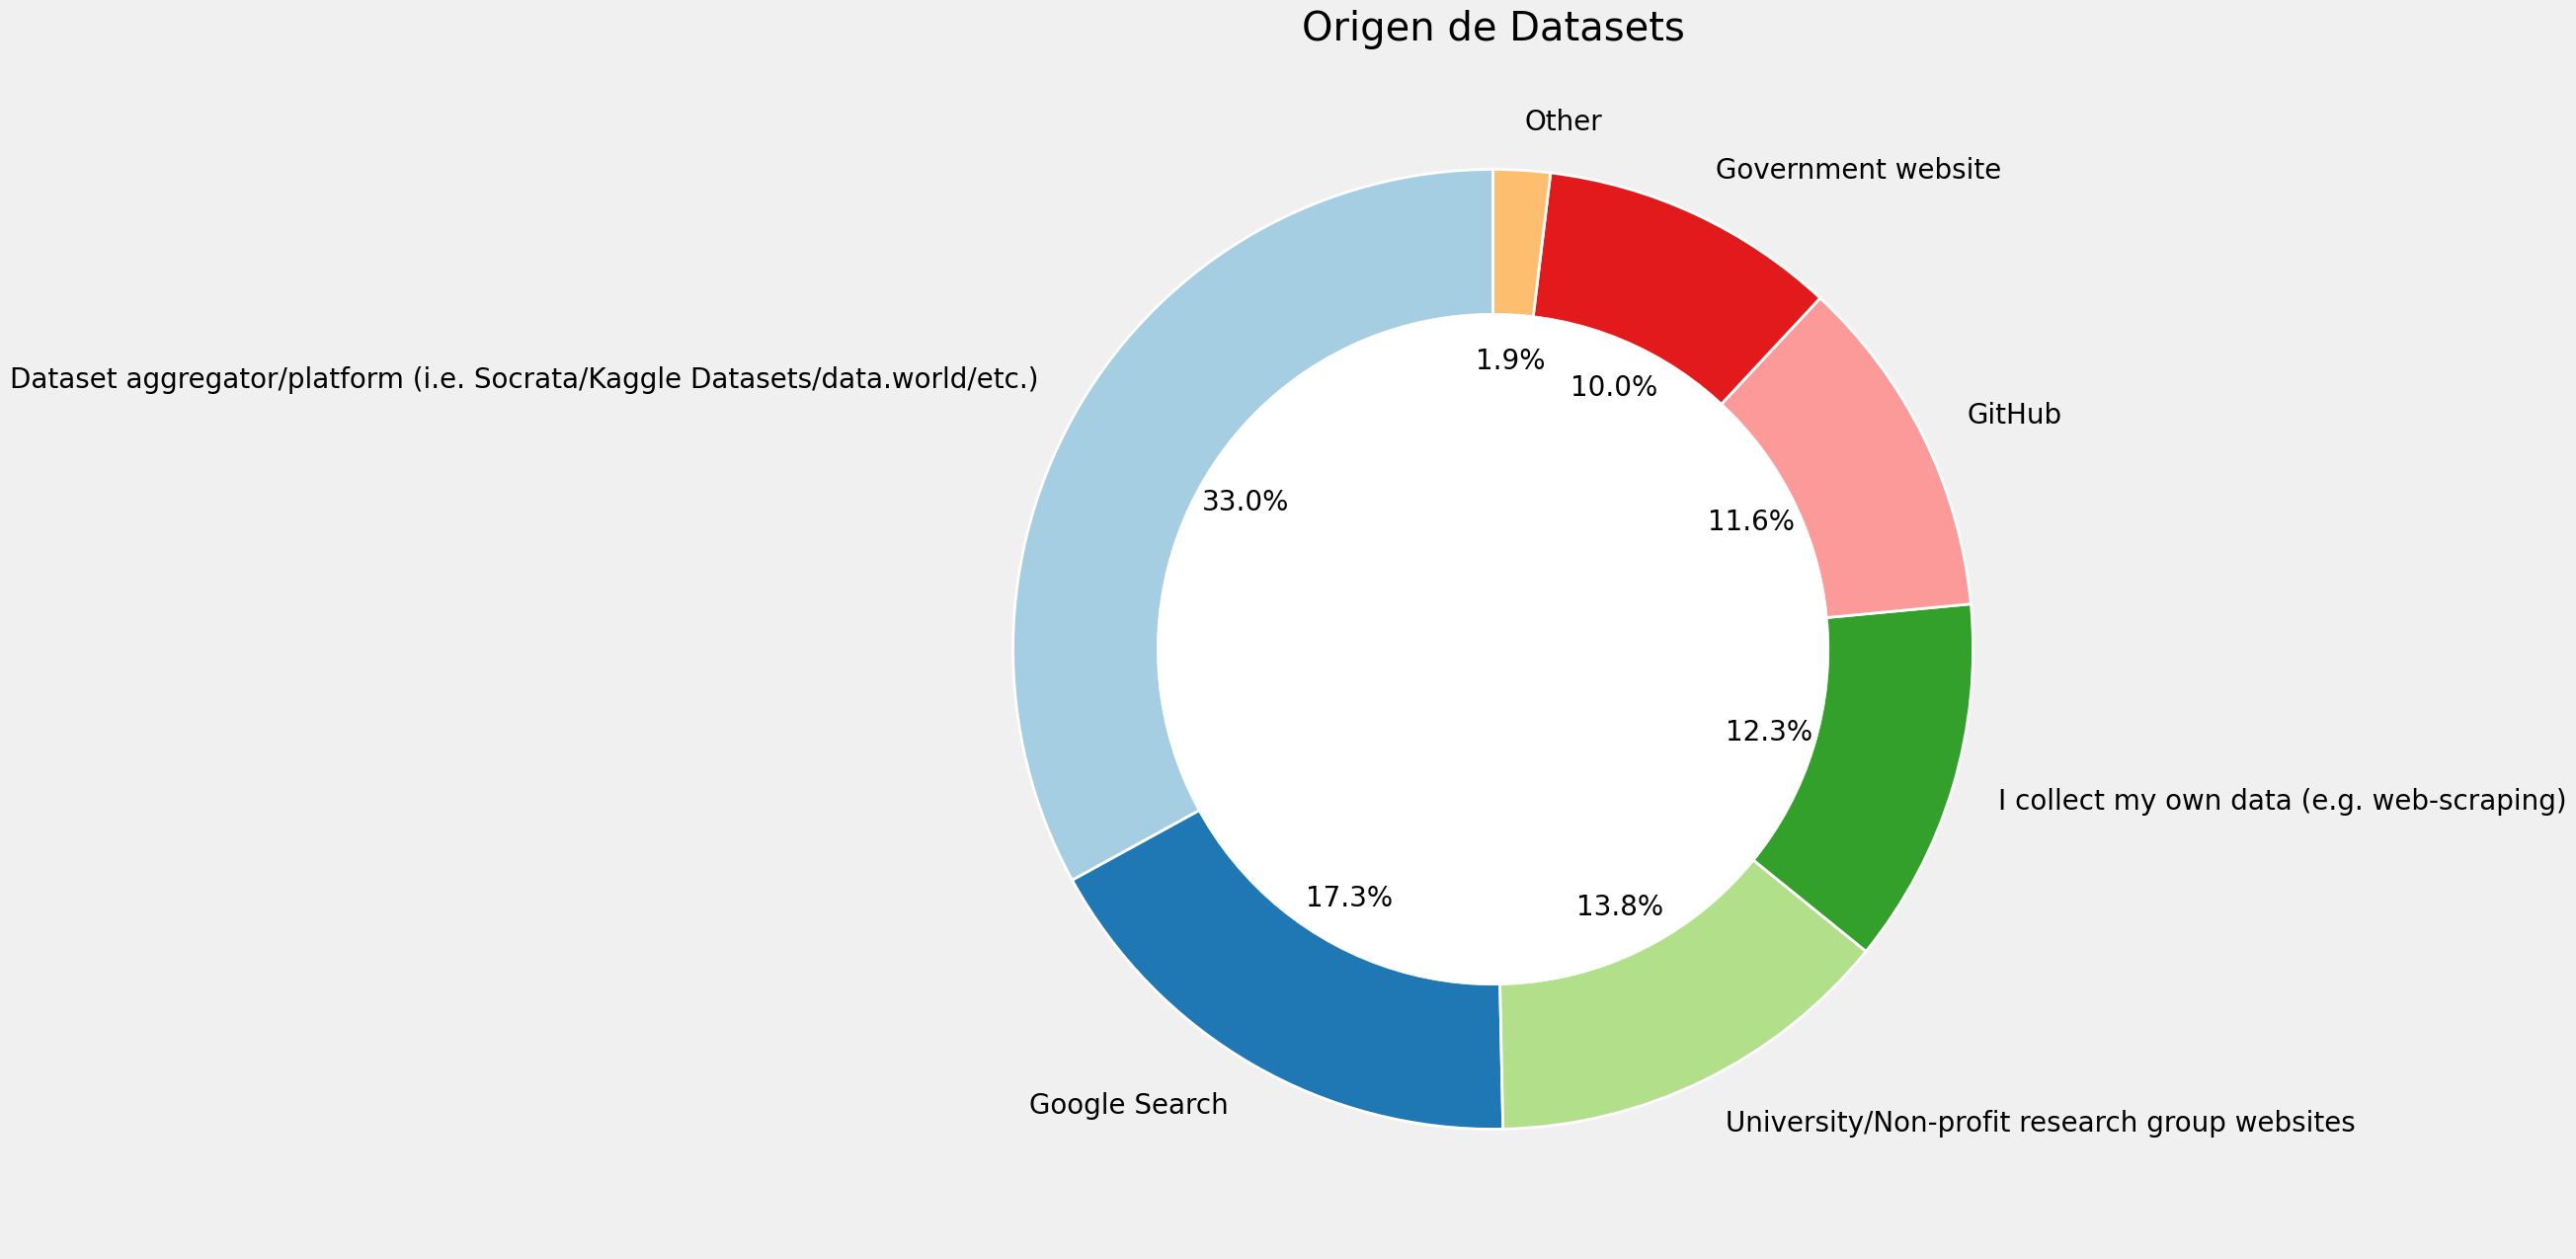

In [45]:
plt.subplots(figsize=(15,15))
data=response['PublicDatasetsSelect'].str.split(',')
dataset=[]
for i in data.dropna():
    dataset.extend(i)
pd.Series(dataset).value_counts().plot.pie(autopct='%1.1f%%',colors=sns.color_palette('Paired',10),startangle=90,wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' })
plt.title('Origen de Datasets')
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.ylabel('')
plt.show()

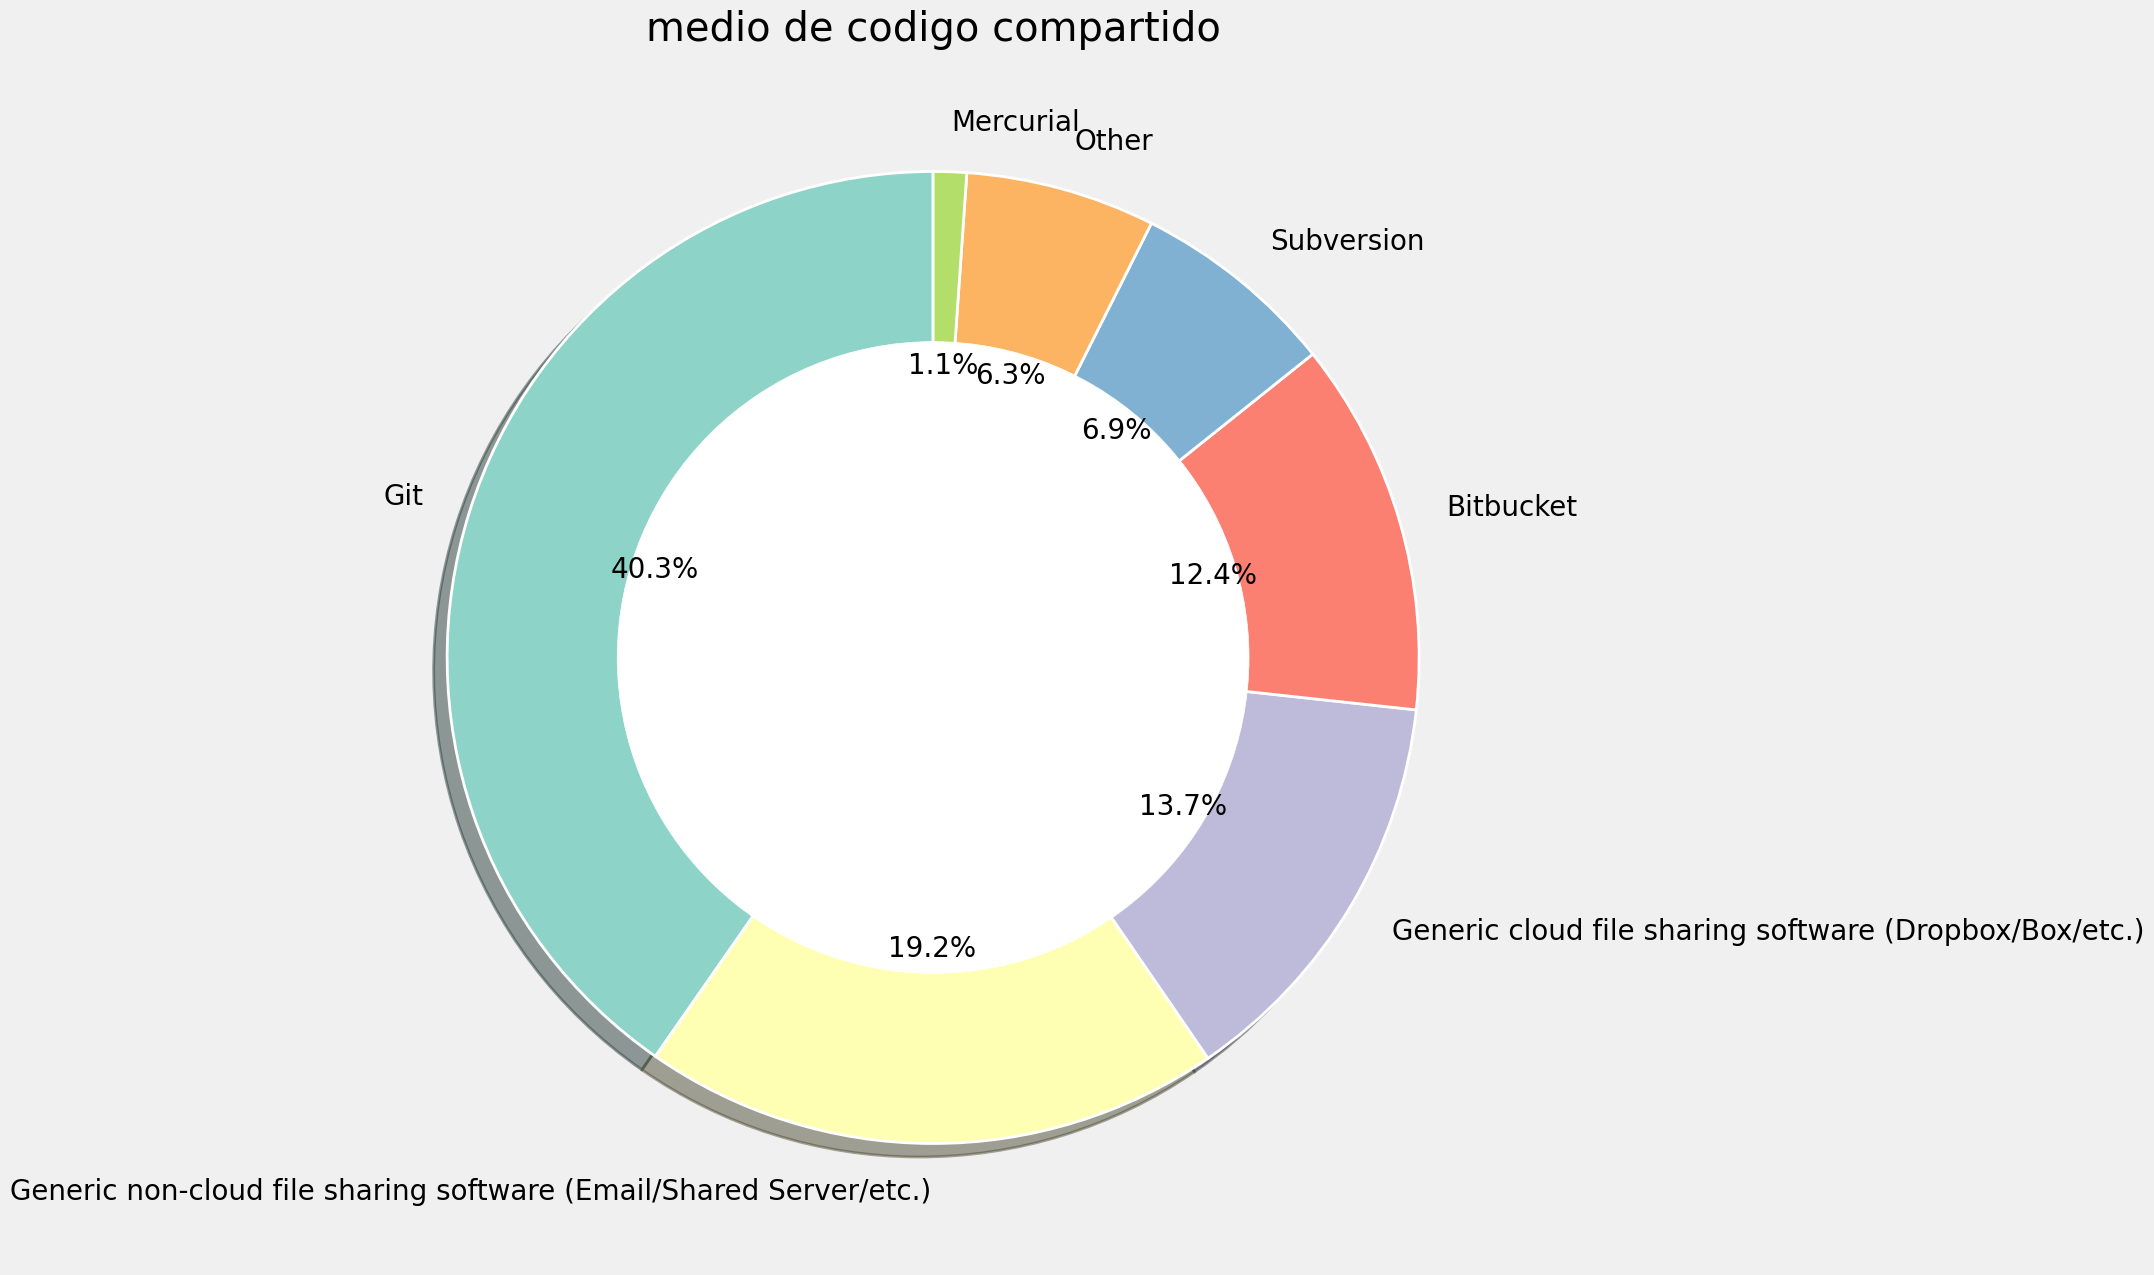

In [46]:
plt.subplots(figsize=(15,15))
code=response['WorkCodeSharing'].str.split(',')
code_share=[]
for i in code.dropna():
    code_share.extend(i)
pd.Series(code_share).value_counts().plot.pie(autopct='%1.1f%%',shadow=True,colors=sns.color_palette('Set3',10),startangle=90,wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' })
plt.title('medio de codigo compartido')
my_circle=plt.Circle( (0,0), 0.65, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.ylabel('')
plt.show()

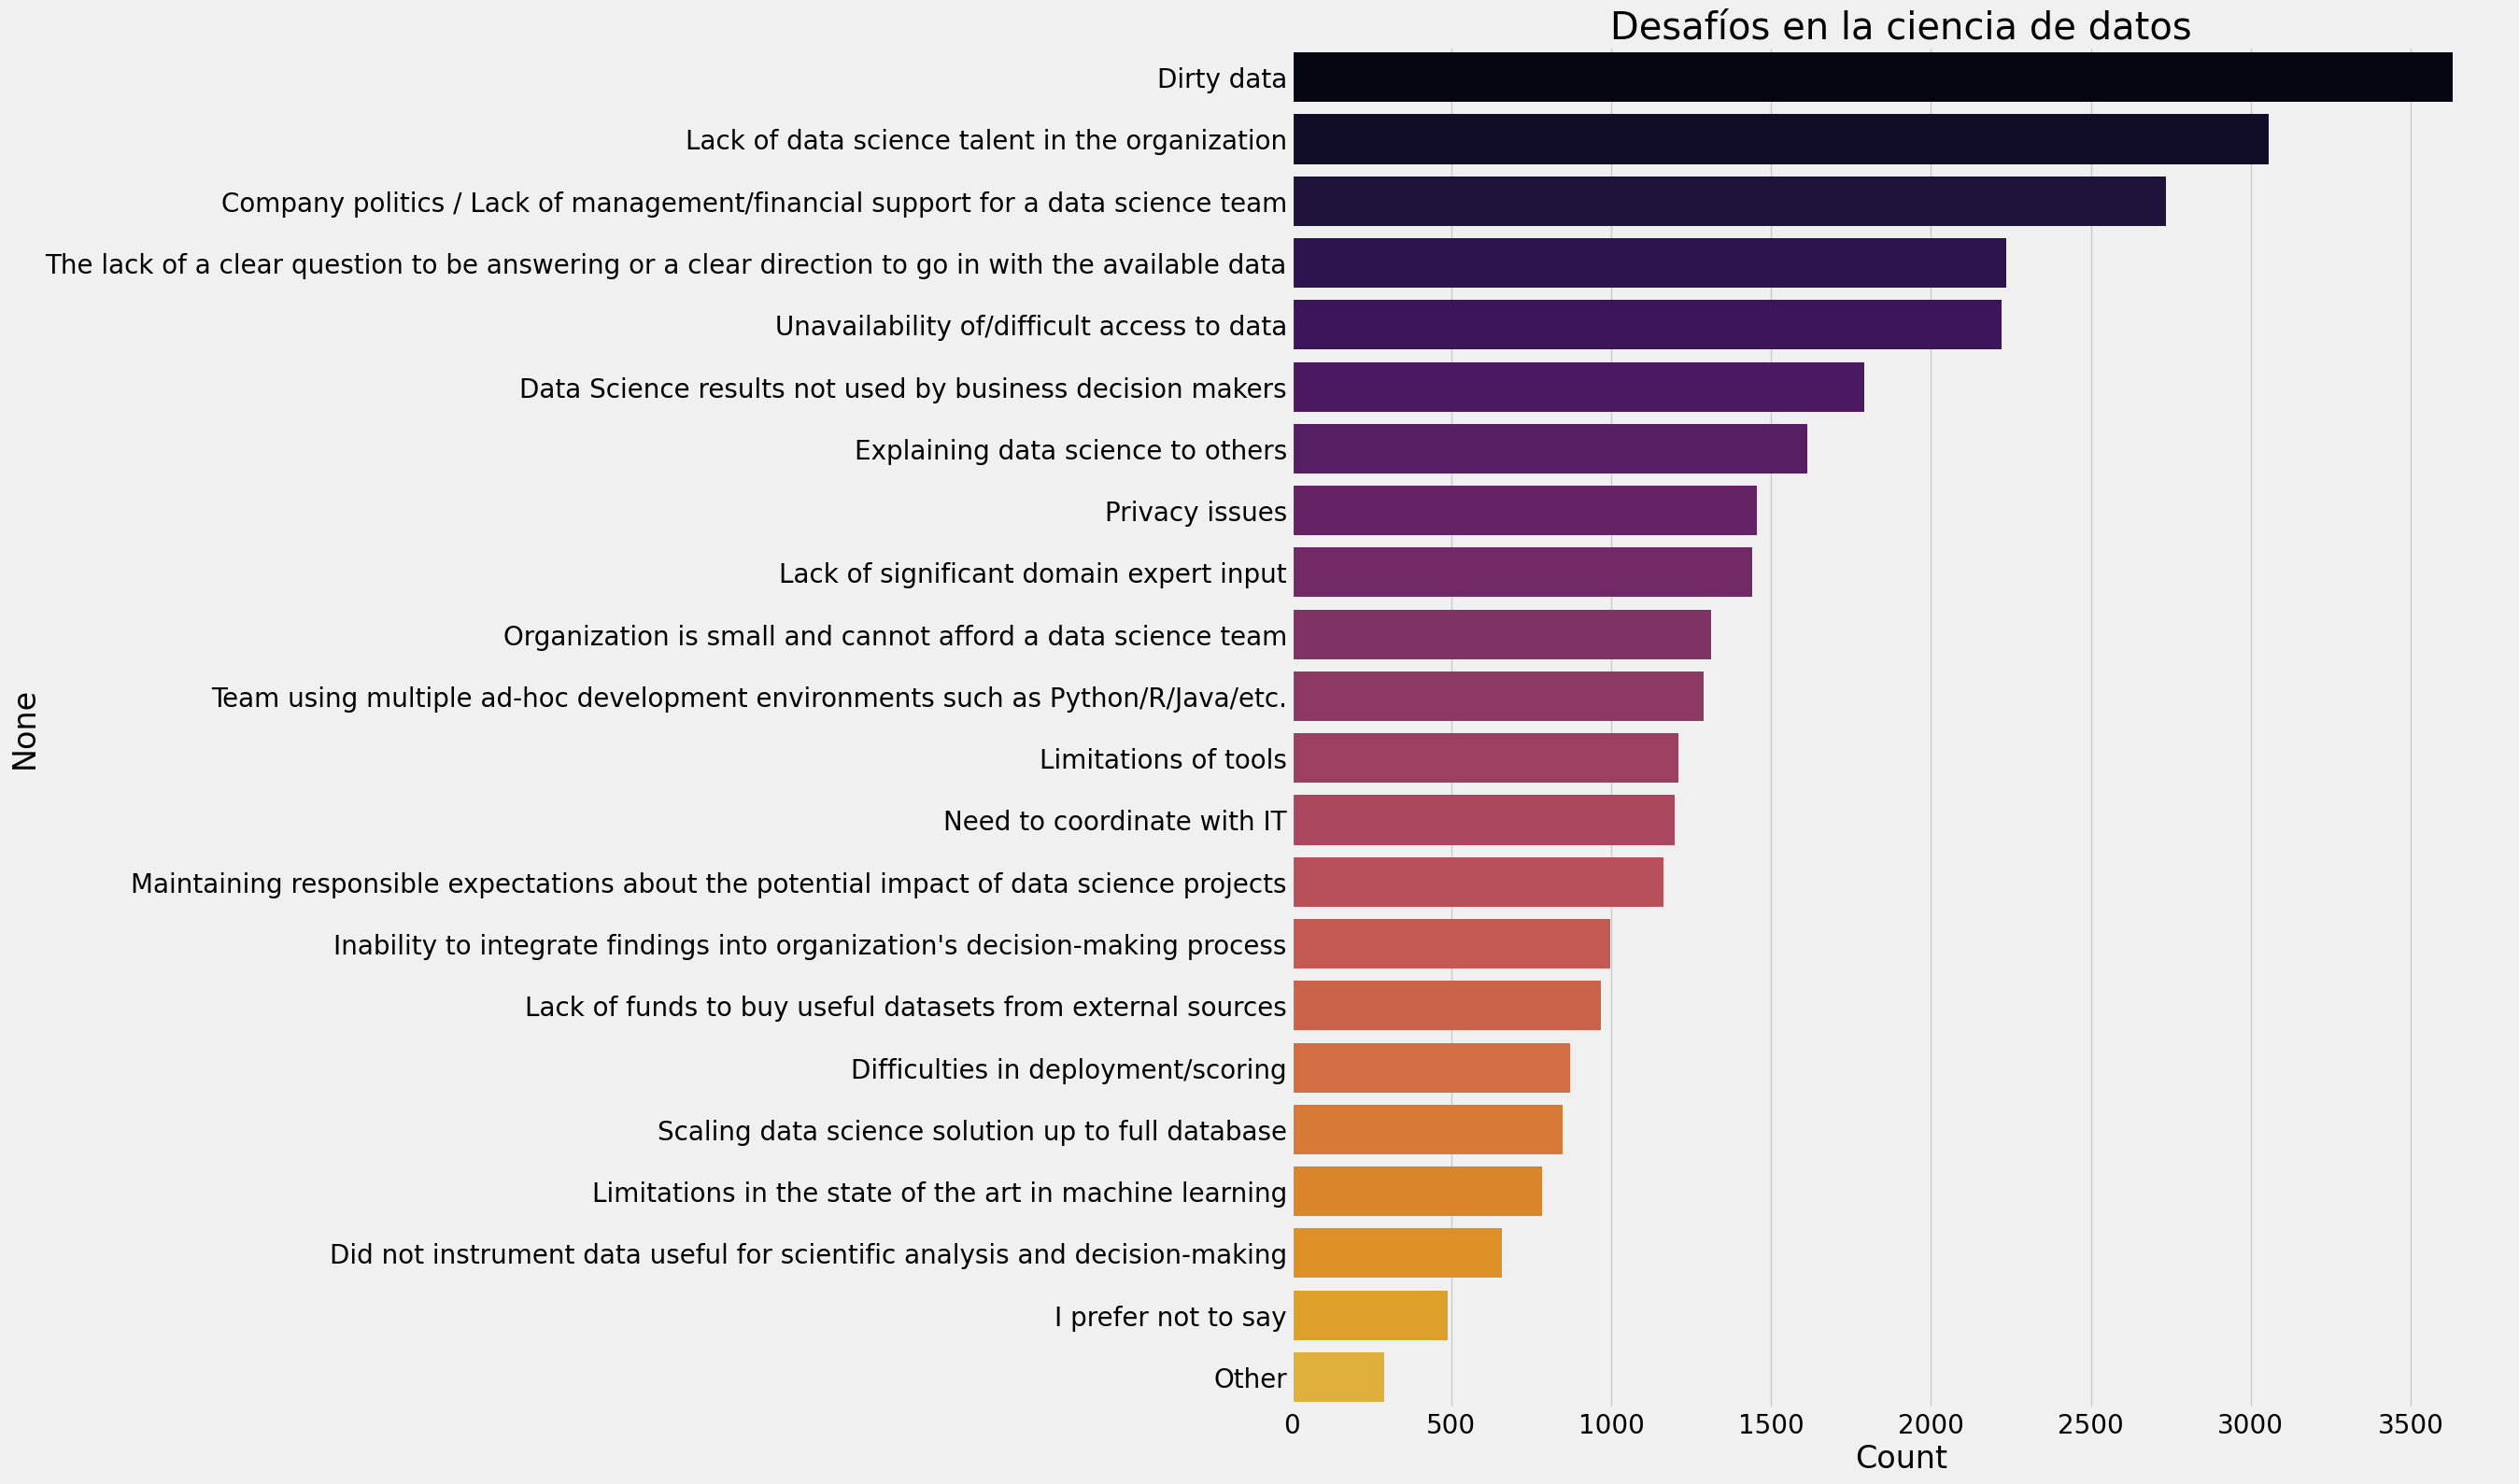

In [47]:
plt.subplots(figsize=(15, 18))

# Procesar los desafíos
challenge = response['WorkChallengesSelect'].str.split(',')
challenges = []
for i in challenge.dropna():
    challenges.extend(i)

# Crear un DataFrame con los desafíos contados
plt1 = pd.Series(challenges).value_counts().sort_values(ascending=False).to_frame()
plt1.columns = ['Count']  # Asignar un nombre a la columna

# Graficar los desafíos
sns.barplot(x='Count', y=plt1.index, data=plt1, palette=sns.color_palette('inferno', 25))
plt.title('Desafíos en la ciencia de datos')

# Mostrar el gráfico
plt.show()


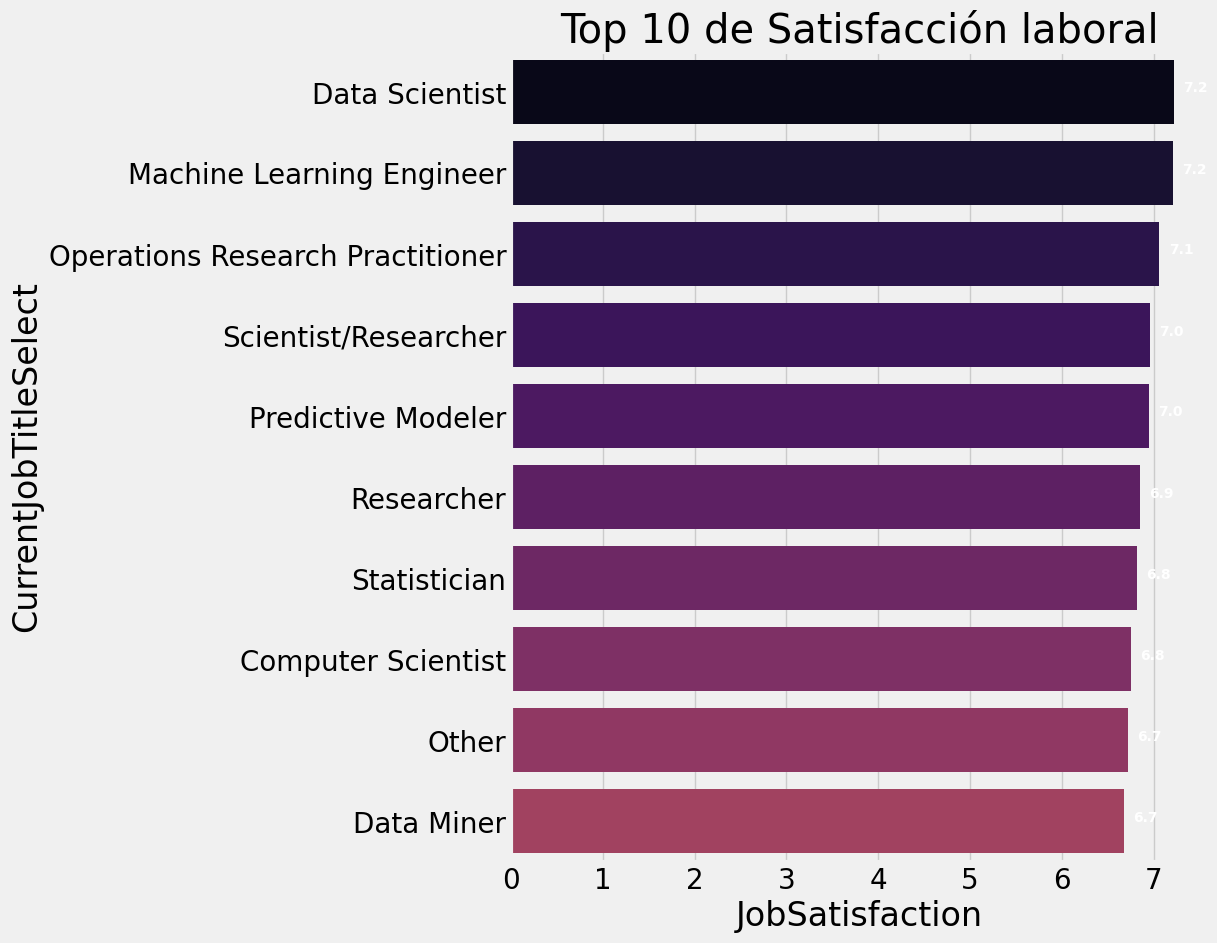

In [48]:
satisfy = response.copy()

# Reemplazar valores en la columna 'JobSatisfaction' usando np.nan
satisfy['JobSatisfaction'].replace({
    '10 - Highly Satisfied': '10',
    '1 - Highly Dissatisfied': '1',
    'I prefer not to share': np.nan  # Cambiar np.NaN por np.nan
}, inplace=True)

# Eliminar valores nulos de 'JobSatisfaction'
satisfy.dropna(subset=['JobSatisfaction'], inplace=True)

# Convertir 'JobSatisfaction' a entero
satisfy['JobSatisfaction'] = satisfy['JobSatisfaction'].astype(int)

# Agrupar por título de trabajo y calcular la satisfacción promedio
satisfy_job = satisfy.groupby(['CurrentJobTitleSelect'])['JobSatisfaction'].mean().sort_values(ascending=False).head(10).to_frame()

# Crear el gráfico de barras
ax = sns.barplot(y=satisfy_job.index, x=satisfy_job['JobSatisfaction'], palette=sns.color_palette('inferno', 20))

# Ajustar el tamaño de la figura
fig = plt.gcf()
fig.set_size_inches(8, 10)

# Añadir los valores en las barras
for i, v in enumerate(satisfy_job['JobSatisfaction']): 
    ax.text(v + 0.1, i, f'{v:.1f}', fontsize=10, color='white', weight='bold')

# Título del gráfico
plt.title('Top 10 de Satisfacción laboral')
plt.show()


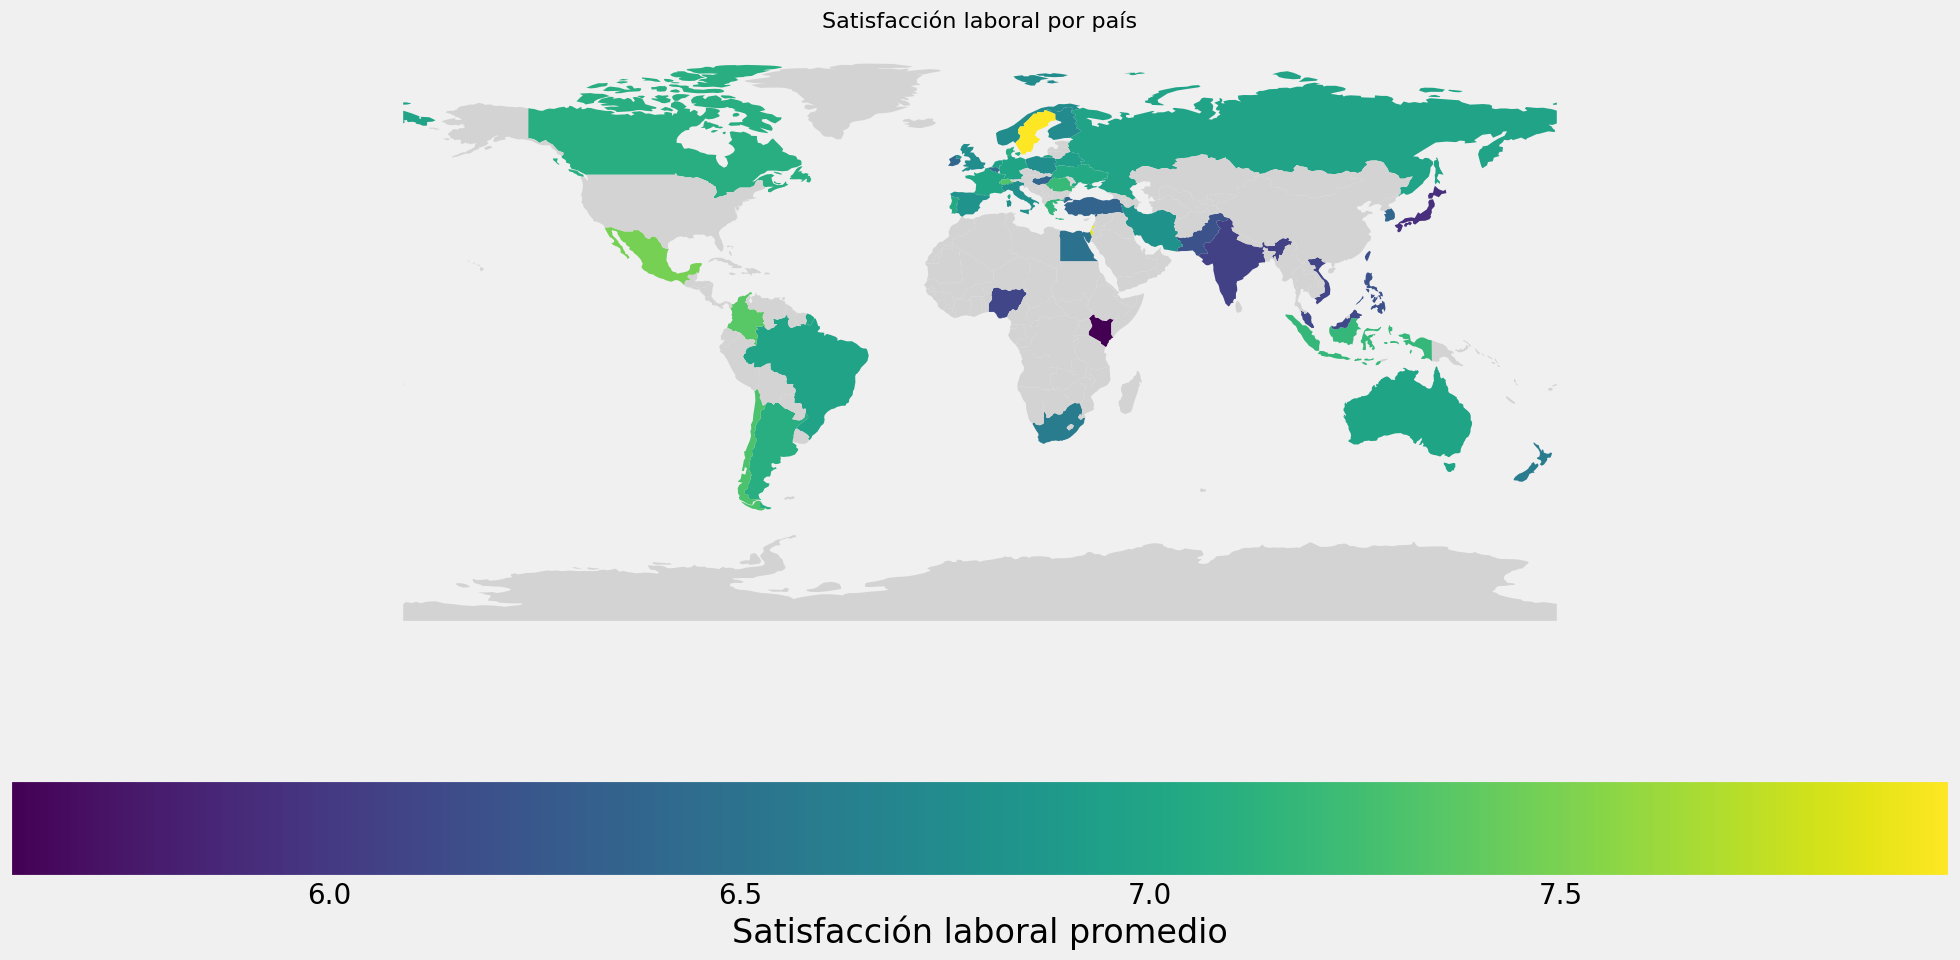

In [49]:
# Asumiendo que los pasos previos de preparación de datos son los mismos
satisfy = response.copy()

# Reemplazar valores en la columna 'JobSatisfaction' usando np.nan
satisfy['JobSatisfaction'].replace({
    '10 - Highly Satisfied': '10',
    '1 - Highly Dissatisfied': '1',
    'I prefer not to share': np.nan
}, inplace=True)

# Eliminar valores nulos de 'JobSatisfaction'
satisfy.dropna(subset=['JobSatisfaction'], inplace=True)

# Convertir 'JobSatisfaction' a entero
satisfy['JobSatisfaction'] = satisfy['JobSatisfaction'].astype(int)

# Agrupar por país y calcular la satisfacción promedio
satisfy_job = satisfy.groupby(['Country'])['JobSatisfaction'].mean().sort_values(ascending=True).to_frame()

# Descargar y cargar el mapa mundial
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
response = requests.get(url)
world = gpd.read_file(io.BytesIO(response.content))

# Fusionar los datos de satisfacción con el mapa mundial
world = world.merge(satisfy_job, how='left', left_on=['NAME'], right_on=['Country'])

# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
world.plot(column='JobSatisfaction', ax=ax, legend=True,
           legend_kwds={'label': 'Satisfacción laboral promedio',
                        'orientation': 'horizontal'},
           missing_kwds={'color': 'lightgrey'})

# Añadir título
ax.set_title('Satisfacción laboral por país', fontsize=16)

# Eliminar ejes
ax.axis('off')

plt.tight_layout()
plt.show()